# **Basic Features**

## **ADL1**

In [ ]:
import numpy as np
import os
import json
import csv

# =========================================================
# === Helper geometry functions (same as before) ==========
# =========================================================

def calculate_trunk_pitch_angle(hip_keypoint, neck_keypoint, y_down=True, right=False):
    dx = neck_keypoint[0] - hip_keypoint[0]
    dy = neck_keypoint[1] - hip_keypoint[1]
    angle_rad = np.arctan2(dx, -dy) if y_down else np.arctan2(dx, dy)
    angle_deg = np.degrees(angle_rad)
    return angle_deg if right else -angle_deg


def calculate_knee_angle(hip_keypoint, knee_keypoint, side):
    vector_hip_to_knee = knee_keypoint - hip_keypoint
    if side == "left":
        vector_hip_to_knee = -vector_hip_to_knee
    angle_rad = np.arctan2(vector_hip_to_knee[1], vector_hip_to_knee[0])
    angle_deg = np.degrees(angle_rad)
    return angle_deg


def process_knee_angles(side, hip_keypoint, knee_keypoint):
    if side == "right":
        return calculate_knee_angle(hip_keypoint, knee_keypoint, side)
    elif side == "left":
        return -calculate_knee_angle(hip_keypoint, knee_keypoint, side)
    else:
        return None


def calculate_elbow_angle(shoulder_keypoint, elbow_keypoint, wrist_keypoint):
    v1 = elbow_keypoint - shoulder_keypoint
    v2 = wrist_keypoint - elbow_keypoint
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))


def calculate_shoulder_asymmetry(left_shoulder, right_shoulder):
    L = np.asarray(left_shoulder, float)
    R = np.asarray(right_shoulder, float)
    if L[0] > R[0]:  # swap if mislabeled
        L, R = R, L
    dx = R[0] - L[0]
    dy = R[1] - L[1]
    ang = np.degrees(np.arctan2(dy, dx))
    ang = ((ang + 90) % 180) - 90  # normalize
    return -ang  # right shoulder higher = positive


def calculate_hand_height_asymmetry(left_wrist, right_wrist, left_shoulder, right_shoulder):
    shoulder_dist = np.linalg.norm(left_shoulder - right_shoulder)
    if shoulder_dist == 0:
        return 0.0
    dy = abs(left_wrist[1] - right_wrist[1])
    return dy / shoulder_dist


def calculate_wrist_normalized_positions(left_shoulder, right_shoulder, left_wrist, right_wrist):
    shoulder_width = np.linalg.norm(right_shoulder - left_shoulder)
    if shoulder_width == 0:
        return 0.0, 0.0
    left_wrist_norm = (left_wrist[1] - left_shoulder[1]) / shoulder_width
    right_wrist_norm = (right_wrist[1] - right_shoulder[1]) / shoulder_width
    return left_wrist_norm, right_wrist_norm


# =========================================================
# === File paths and setup =================================
# =========================================================

fps = 50.0
valid_suffixes = ['ADL1S', 'ADL1F']

#Brasil
# video_root_directory = '/content/drive/MyDrive/Wheelchair_Project/PB_selected_videos/'
# json_root_directory = '/content/drive/MyDrive/Wheelchair_Project/30_10/VitSpineSmoothed/'
# base_output_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL1/'

#Poland
video_root_directory = '/content/drive/MyDrive/Wheelchair_Project/All_videos/'
json_root_directory = '/content/drive/MyDrive/Wheelchair_Project/13_10/VitSpineXLSmoothed/'
base_output_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/'

folders = {
    'frontal_csv': os.path.join(base_output_dir, 'frontal/csv'),
    'sagittal_csv': os.path.join(base_output_dir, 'sagittal/csv')
}
for path in folders.values():
    os.makedirs(path, exist_ok=True)

# Collect JSON files only
json_files = []
for root, _, files in os.walk(json_root_directory):
    for f in files:
        if f.endswith('.json') and any(tag in f for tag in valid_suffixes):
            json_files.append(os.path.join(root, f))


# =========================================================
# === SAGITTAL JSON-ONLY PROCESSING ========================
# =========================================================
def process_sagittal_json(json_file, csv_path):

    with open(json_file, 'r') as fh:
        data = json.load(fh)

    frames = data.get('frames', [])

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "Time (s)",
            "TrunkPitch(deg)",
            "KneeAngle(deg)",
            "ElbowAngle(deg)",
            "HeadPitch(deg)"
        ])

        for idx, frame_data in enumerate(frames):

            kp_spine = np.array(frame_data['spine_keypoints'])
            hip, neck, head = kp_spine[-1][:2], kp_spine[2][:2], kp_spine[0][:2]

            kp = np.array(frame_data['keypoints'])
            side = frame_data.get("side", "").strip()

            if side == "left":
                shoulder, elbow, wrist = kp[5][:2], kp[7][:2], kp[9][:2]
                knee = kp[14][:2]
            else:
                shoulder, elbow, wrist = kp[6][:2], kp[8][:2], kp[10][:2]
                knee = kp[13][:2]

            trunk_angle = calculate_trunk_pitch_angle(hip, neck, True, side == "right")
            elbow_angle = calculate_elbow_angle(shoulder, elbow, wrist)
            knee_angle = process_knee_angles(side, hip, knee)
            head_pitch = calculate_trunk_pitch_angle(neck, head, True, side == "right")

            t = idx / fps

            writer.writerow([
                t, trunk_angle, knee_angle, elbow_angle, head_pitch
            ])

    print(f"[OK] Sagittal CSV saved: {csv_path}")


# =========================================================
# === FRONTAL JSON-ONLY PROCESSING ========================
# =========================================================
def process_frontal_json(json_file, csv_path):

    with open(json_file, 'r') as fh:
        data = json.load(fh)

    frames = data.get('frames', [])

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "Time (s)",
            "ShoulderAsym(deg)",
            "HandAsym(norm)",
            "LeftWristNorm",
            "RightWristNorm"
        ])

        for idx, frame_data in enumerate(frames):

            kp = np.array(frame_data['keypoints'])
            left_shoulder, right_shoulder = kp[5][:2], kp[6][:2]
            left_wrist, right_wrist = kp[9][:2], kp[10][:2]

            shoulder_asym = calculate_shoulder_asymmetry(left_shoulder, right_shoulder)
            hand_asym = calculate_hand_height_asymmetry(left_wrist, right_wrist,
                                                        left_shoulder, right_shoulder)

            left_wrist_norm, right_wrist_norm = calculate_wrist_normalized_positions(
                left_shoulder, right_shoulder, left_wrist, right_wrist
            )

            t = idx / fps

            writer.writerow([
                t, shoulder_asym, hand_asym, left_wrist_norm, right_wrist_norm
            ])

    print(f"[OK] Frontal CSV saved: {csv_path}")


# =========================================================
# === MAIN DISPATCH LOOP (JSON ONLY) ======================
# =========================================================



for json_file in json_files:
    filename = os.path.basename(json_file).split(".")[0]

    # remove "_poses" from the filename
    clean_name = filename.replace("_poses", "")

    if "F" in filename:
        csv_path = os.path.join(folders['frontal_csv'], f"{clean_name}_frontal.csv")
        process_frontal_json(json_file, csv_path)

    elif "S" in filename:
        csv_path = os.path.join(folders['sagittal_csv'], f"{clean_name}_sagittal.csv")
        process_sagittal_json(json_file, csv_path)


[OK] Sagittal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/sagittal/csv/PP07ADL1S_sagittal.csv
[OK] Frontal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/frontal/csv/PP07ADL1F_frontal.csv
[OK] Frontal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/frontal/csv/PP01ADL1F_frontal.csv
[OK] Sagittal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/sagittal/csv/PP01ADL1S_sagittal.csv
[OK] Sagittal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/sagittal/csv/PP06ADL1S_sagittal.csv
[OK] Frontal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/frontal/csv/PP06ADL1F_frontal.csv
[OK] Frontal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/frontal/csv/PP25ADL1F_frontal.csv
[OK] Sagittal CSV saved: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/sagittal/csv/PP25ADL1S_sagittal.

## **ADL2**



In [ ]:
import numpy as np
import json
import csv
import os

# =========================================================
# === Geometry functions for ADL2 (Wheelie stability) =====
# =========================================================

def calculate_trunk_pitch_angle(hip_keypoint, neck_keypoint, y_down=True, right=False):
    """Sagittal plane trunk tilt (forward/backward)."""
    dx = neck_keypoint[0] - hip_keypoint[0]
    dy = neck_keypoint[1] - hip_keypoint[1]
    angle_rad = np.arctan2(dx, -dy) if y_down else np.arctan2(dx, dy)
    angle_deg = np.degrees(angle_rad)
    return angle_deg if right else -angle_deg


def calculate_trunk_roll(neck, hip):
    """Frontal plane trunk side tilt (0° upright)."""
    dx = neck[0] - hip[0]
    dy = neck[1] - hip[1]
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)
    roll = angle_deg - 90
    roll = ((roll + 90) % 180) - 90
    return roll


def calculate_head_roll(left_ear, right_ear):
    """Frontal plane head tilt."""
    L, R = np.asarray(left_ear, float), np.asarray(right_ear, float)
    dx = R[0] - L[0]
    dy = R[1] - L[1]
    ang = np.degrees(np.arctan2(dy, dx))
    ang = ((ang + 90) % 180) - 90
    return -ang


# ============================
# === Your angle functions ===
# ============================


def calculate_knee_angle(hip_keypoint, knee_keypoint, side):
    vector_hip_to_knee = knee_keypoint - hip_keypoint
    if side == "left":
        vector_hip_to_knee = -vector_hip_to_knee
    angle_rad = np.arctan2(vector_hip_to_knee[1], vector_hip_to_knee[0])
    angle_deg = np.degrees(angle_rad)
    return angle_deg


def process_knee_angles(side, hip_keypoint, knee_keypoint):
    if side == "right":
        return calculate_knee_angle(hip_keypoint, knee_keypoint, side)
    elif side == "left":
        return -calculate_knee_angle(hip_keypoint, knee_keypoint, side)
    else:
        return None


def calculate_elbow_angle(shoulder_keypoint, elbow_keypoint, wrist_keypoint):
    v1 = elbow_keypoint - shoulder_keypoint
    v2 = wrist_keypoint - elbow_keypoint
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))


# =========================================================
# === File organization ===================================
# =========================================================

fps = 50.0
valid_suffixes = ['ADL2S', 'ADL2F']

# video_root_directory = '/content/drive/MyDrive/Wheelchair_Project/PB_selected_videos/'
# json_root_directory = '/content/drive/MyDrive/Wheelchair_Project/30_10/VitSpineSmoothed/'
# base_output_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL2/'


video_root_directory = '/content/drive/MyDrive/Wheelchair_Project/All_videos/'
json_root_directory = '/content/drive/MyDrive/Wheelchair_Project/13_10/VitSpineXLSmoothed/'
base_output_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/'

folders = {
    'frontal_csv': os.path.join(base_output_dir, 'frontal/csv'),
    'sagittal_csv': os.path.join(base_output_dir, 'sagittal/csv')
}

for p in folders.values():
    os.makedirs(p, exist_ok=True)


# =========================================================
# === Collect JSON files only =============================
# =========================================================

json_files = []
for root, _, files in os.walk(json_root_directory):
    for f in files:
        if f.endswith('.json') and any(tag in f for tag in valid_suffixes):
            json_files.append(os.path.join(root, f))


# ===============================================
# === Sagittal JSON-only processing (pitch) =====
# ===============================================
def process_sagittal_json(json_file, csv_path):
    with open(json_file, 'r') as fh:
        data = json.load(fh)
    frames = data.get('frames', [])

    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Time (s)', 'TrunkPitch(deg)', 'KneeAngle(deg)', 'ElbowAngle(deg)'])

        for idx, frame_data in enumerate(frames):
            side = frame_data.get("side", "").strip()
            kp_spine = np.array(frame_data['spine_keypoints'])
            kp = np.array(frame_data['keypoints'])

            hip = kp_spine[-1][:2]
            neck = kp_spine[2][:2]

            # Select correct arm + leg keypoints
            if side == "left":
                shoulder, elbow, wrist = kp[5][:2], kp[7][:2], kp[9][:2]
                knee = kp[14][:2]
            else:
                shoulder, elbow, wrist = kp[6][:2], kp[8][:2], kp[10][:2]
                knee = kp[13][:2]

            # Compute angles
            trunk_pitch = calculate_trunk_pitch_angle(hip, neck, y_down=True, right=(side == "right"))
            elbow_angle = calculate_elbow_angle(shoulder, elbow, wrist)
            knee_angle = process_knee_angles(side=side, hip_keypoint=hip, knee_keypoint=knee)

            t = idx / fps
            writer.writerow([t, trunk_pitch, knee_angle, elbow_angle])

    print(f"[OK] Sagittal JSON processed -> {csv_path}")


# ==============================================
# === Frontal JSON-only processing (roll) ======
# ==============================================
def process_frontal_json(json_file, csv_path):
    with open(json_file, 'r') as fh:
        data = json.load(fh)
    frames = data.get('frames', [])

    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Time (s)', 'TrunkRoll(deg)', 'HeadRoll(deg)'])

        for idx, frame_data in enumerate(frames):
            kp = np.array(frame_data['keypoints'])
            left_ear = kp[3][:2]
            right_ear = kp[4][:2]

            kp_spine = np.array(frame_data['spine_keypoints'])
            hip = kp_spine[-1][:2]
            neck = kp_spine[2][:2]

            trunk_roll = calculate_trunk_roll(neck, hip)
            head_roll = calculate_head_roll(left_ear, right_ear)

            t = idx / fps
            writer.writerow([t, trunk_roll, head_roll])

    print(f"[OK] Frontal JSON processed -> {csv_path}")


# =========================================================
# === Main loop — JSON → CSV (no videos!!) ================
# =========================================================

for json_file in json_files:
    filename = os.path.basename(json_file).split(".")[0]

    # remove "_poses" from the filename
    clean_name = filename.replace("_poses", "")

    if "F" in filename:
        csv_path = os.path.join(folders['frontal_csv'], f"{clean_name}_frontal.csv")
        process_frontal_json(json_file, csv_path)

    elif "S" in filename:
        csv_path = os.path.join(folders['sagittal_csv'], f"{clean_name}_sagittal.csv")
        process_sagittal_json(json_file, csv_path)



[OK] Frontal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/frontal/csv/PP07ADL2F_frontal.csv
[OK] Sagittal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/sagittal/csv/PP07ADL2S_sagittal.csv
[OK] Frontal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/frontal/csv/PP01ADL2F_frontal.csv
[OK] Sagittal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/sagittal/csv/PP01ADL2S_sagittal.csv
[OK] Frontal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/frontal/csv/PP06ADL2F_frontal.csv
[OK] Sagittal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/sagittal/csv/PP06ADL2S_sagittal.csv
[OK] Frontal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/frontal/csv/PP25ADL2F_frontal.csv
[OK] Sagittal JSON processed -> /content/drive/MyDrive/Wheelchair_Project/

## **ADL3**

In [ ]:
import numpy as np
import os, json, csv
from scipy.signal import savgol_filter

# ======================
# Geometry Functions
# ======================

def calculate_trunk_pitch_angle(hip, neck, y_down=True, right=False):
    dx = neck[0] - hip[0]
    dy = neck[1] - hip[1]
    ang = np.degrees(np.arctan2(dx, -dy) if y_down else np.arctan2(dx, dy))
    return ang if right else -ang

def calculate_head_pitch(neck, head, y_down=True, right=False):
    dx = head[0] - neck[0]
    dy = head[1] - neck[1]
    ang = np.degrees(np.arctan2(dx, -dy) if y_down else np.arctan2(dx, dy))
    return ang if right else -ang

def calculate_pelvis_pitch(spine_03, hip, y_down=True, right=False):
    dx = spine_03[0] - hip[0]
    dy = spine_03[1] - hip[1]
    ang = np.degrees(np.arctan2(dx, -dy) if y_down else np.arctan2(dx, dy))
    return ang if right else -ang

def calculate_trunk_roll(neck, hip):
    dx = neck[0] - hip[0]
    dy = neck[1] - hip[1]
    roll = np.degrees(np.arctan2(dy, dx)) - 90
    return ((roll + 90) % 180) - 90

def calculate_shoulder_asymmetry(L, R):
    L, R = np.asarray(L, float), np.asarray(R, float)
    if L[0] > R[0]:
        L, R = R, L
    dx, dy = R[0]-L[0], R[1]-L[1]
    ang = np.degrees(np.arctan2(dy, dx))
    ang = ((ang + 90) % 180) - 90
    return -ang

def calculate_hand_height_asymmetry(Lw, Rw, Ls, Rs):
    shoulder_dist = np.linalg.norm(Ls - Rs)
    if shoulder_dist == 0:
        return 0.0
    dy = abs(Lw[1] - Rw[1])
    return dy / shoulder_dist


def calculate_knee_angle(hip_keypoint, knee_keypoint, side):
    vector_hip_to_knee = knee_keypoint - hip_keypoint
    if side == "left":
        vector_hip_to_knee = -vector_hip_to_knee
    angle_rad = np.arctan2(vector_hip_to_knee[1], vector_hip_to_knee[0])
    angle_deg = np.degrees(angle_rad)
    return angle_deg


def process_knee_angles(side, hip_keypoint, knee_keypoint):
    if side == "right":
        return calculate_knee_angle(hip_keypoint, knee_keypoint, side)
    elif side == "left":
        return -calculate_knee_angle(hip_keypoint, knee_keypoint, side)
    else:
        return None


def calculate_elbow_angle(shoulder_keypoint, elbow_keypoint, wrist_keypoint):
    v1 = elbow_keypoint - shoulder_keypoint
    v2 = wrist_keypoint - elbow_keypoint
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))


# ======================
# JSON-Only Processing
# ======================

fps = 50.0

def process_sagittal_json(json_file, csv_path):
    with open(json_file, 'r') as fh:
        data = json.load(fh)
    frames = data.get('frames', [])

    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'Time(s)',
            'TrunkPitch(deg)',
            'PelvisPitch(deg)',
            'HeadPitch(deg)',
            'KneeAngle(deg)',
            'ElbowAngle(deg)'
        ])

        for idx, fr in enumerate(frames):
            side = fr.get("side", "").strip()

            kp_spine = np.array(fr['spine_keypoints'])
            kp = np.array(fr['keypoints'])

            hip = kp_spine[-1][:2]
            neck = kp_spine[2][:2]
            head = kp_spine[0][:2]
            spine03 = kp_spine[5][:2]

            if side == "left":
                shoulder, elbow, wrist = kp[5][:2], kp[7][:2], kp[9][:2]
                knee = kp[14][:2]
            else:
                shoulder, elbow, wrist = kp[6][:2], kp[8][:2], kp[10][:2]
                knee = kp[13][:2]

            trunk_pitch = calculate_trunk_pitch_angle(hip, neck, right=(side=="right"))
            pelvis_pitch = calculate_pelvis_pitch(spine03, hip, right=(side=="right"))
            head_pitch = calculate_head_pitch(neck, head, right=(side=="right"))
            knee_angle = process_knee_angles(side, hip, knee)
            elbow_angle = calculate_elbow_angle(shoulder, elbow, wrist)

            t = idx / fps

            writer.writerow([
                t, trunk_pitch, pelvis_pitch, head_pitch, knee_angle, elbow_angle
            ])

    print(f"[OK] Sagittal CSV saved -> {csv_path}")


def process_frontal_json(json_file, csv_path):
    with open(json_file, 'r') as fh:
        data = json.load(fh)
    frames = data.get('frames', [])

    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'Time(s)',
            'TrunkRoll(deg)',
            'ShoulderAsym(deg)',
            'HandAsym(norm)'
        ])

        for idx, fr in enumerate(frames):
            kp = np.array(fr['keypoints'])

            Ls, Rs = kp[5][:2], kp[6][:2]
            Lw, Rw = kp[9][:2], kp[10][:2]

            kp_spine = np.array(fr['spine_keypoints'])
            neck, hip = kp_spine[2][:2], kp_spine[-1][:2]

            trunk_roll = calculate_trunk_roll(neck, hip)
            shoulder_asym = calculate_shoulder_asymmetry(Ls, Rs)
            hand_asym = calculate_hand_height_asymmetry(Lw, Rw, Ls, Rs)

            t = idx / fps

            writer.writerow([t, trunk_roll, shoulder_asym, hand_asym])

    print(f"[OK] Frontal CSV saved -> {csv_path}")


# ======================
# Paths
# ======================

valid_suffixes = ['ADL3S', 'ADL3F']

video_root_directory = '/content/drive/MyDrive/Wheelchair_Project/PB_selected_videos/'
json_root_directory = '/content/drive/MyDrive/Wheelchair_Project/30_10/VitSpineSmoothed/'
base_output_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/'

# video_root_directory = '/content/drive/MyDrive/Wheelchair_Project/All_videos/'
# json_root_directory = '/content/drive/MyDrive/Wheelchair_Project/13_10/VitSpineXLSmoothed/'
# base_output_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL3/'



folders = {
    'frontal_csv': os.path.join(base_output_dir, 'frontal/csv'),
    'sagittal_csv': os.path.join(base_output_dir, 'sagittal/csv')
}
for p in folders.values():
    os.makedirs(p, exist_ok=True)

video_files, json_files = [], []
for root, _, files in os.walk(video_root_directory):
    for f in files:
        if f.endswith('.avi') and any(tag in f for tag in valid_suffixes):
            video_files.append(os.path.join(root, f))
for root, _, files in os.walk(json_root_directory):
    for f in files:
        if f.endswith('.json') and any(tag in f for tag in valid_suffixes):
            json_files.append(os.path.join(root, f))


# ======================
# Main Loop: JSON only
# ======================

for video_file in video_files:
    video_name = os.path.basename(video_file).split('.')[0]
    matching_json = next((j for j in json_files if video_name in j), None)

    if not matching_json:
        print(f"[WARN] No JSON for {video_name}")
        continue

    if "F" in video_name:
        csv_path = os.path.join(folders['frontal_csv'], f"{video_name}_frontal.csv")
        process_frontal_json(matching_json, csv_path)

    elif "S" in video_name:
        csv_path = os.path.join(folders['sagittal_csv'], f"{video_name}_sagittal.csv")
        process_sagittal_json(matching_json, csv_path)


[OK] Sagittal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/sagittal/csv/PB03ADL3S_sagittal.csv
[OK] Frontal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/frontal/csv/PB03ADL3F_frontal.csv
[OK] Sagittal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/sagittal/csv/PB04ADL3S_sagittal.csv
[OK] Frontal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/frontal/csv/PB04ADL3F_frontal.csv
[OK] Frontal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/frontal/csv/PB07ADL3F_frontal.csv
[OK] Sagittal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/sagittal/csv/PB07ADL3S_sagittal.csv
[OK] Sagittal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/sagittal/csv/PB09ADL3S_sagittal.csv
[OK] Frontal CSV saved -> /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL3/frontal/csv/PB

# **Timing**

In [ ]:
import os
import shutil

root = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/"

for dirpath, dirnames, filenames in os.walk(root):
    # delete matching folders
    for d in list(dirnames):
        if "PB38" in d or "PB43" in d:
            full_path = os.path.join(dirpath, d)
            shutil.rmtree(full_path, ignore_errors=True)
            print("Deleted folder:", full_path)

    # delete matching files
    for f in list(filenames):
        if "PB38" in f or "PB43" in f:
            full_path = os.path.join(dirpath, f)
            os.remove(full_path)
            print("Deleted file:", full_path)

print("✔ Finished deleting everything related to PB38 and PB43.")


Deleted file: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL1/frontal/csv/PB38ADL1F_frontal.csv
Deleted file: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL1/frontal/csv/PB43ADL1F_frontal.csv
Deleted file: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL1/sagittal/csv/PB38ADL1S_sagittal.csv
Deleted file: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL1/sagittal/csv/PB43ADL1S_sagittal.csv
✔ Finished deleting everything related to PB38 and PB43.


In [ ]:
import os
import pandas as pd

# ---- Define your output directory ----
output_dir = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Timing_CSVs/"
os.makedirs(output_dir, exist_ok=True)


# ---- ADL1 ----
data_adl1 = {
    "patient": ["PB03","PB04","PB07","PB09","PB16","PB26","PB27","PB33","PB34","PB35","PB36","PB37","PB41","PB42"],
    "label":   [2,2,2,0,2,0,2,0,1,1,0,0,2,2],
    "trunk peak 1":[2.46,2.64,2.24,2.64,1.88,2.38,2.56,2.5,2.3,2.4,2.0,2.2,2.56,2.66],
    "trunk peak 2":[3.5,4.26,3.22,3.82,2.78,3.56,3.38,4.24,3.26,3.74,2.86,3.28,3.38,3.86],
    "trunk peak 3":[4.34,5.8,4.06,5.02,3.92,5.16,4.26,5.8,4.34,5.28,3.92,4.47,4.56,5.36],
    "trunk peak 4":[5.3,7.28,4.94,6.4,4.94,6.26,5.0,7.48,5.44,6.6,5.04,5.5,6.7,6.88],
    "trunk peak 5":[6.24,8.8,5.86,7.82,5.86,7.7,5.8,9.18,6.48,8.18,6.22,6.72,8.56,8.24],
    "elbow deg pick start(s)":[1.92,1.82,1.76,1.9,1.56,2.06,2.16,2.0,1.74,2.0,1.52,1.8,1.66,1.9],
    "Trunk onset(s)":[1.9,1.78,1.76,1.78,1.6,2.04,2.16,1.96,1.72,2.04,1.2,1.84,1.7,2.24],
    "Handrim contact onset lag (s)":[-0.02,-0.04,0,-0.12,0.04,-0.02,0,-0.04,-0.02,0.04,-0.32,0.04,0.04,0.34],
    "left onset":[2.36,1.82,1.7,2.14,1.64,2.0,2.2,1.98,1.78,2.1,1.52,1.8,1.68,2.02],
    "wrist onset":[2.36,1.8,1.66,2.12,1.64,2.0,2.16,2.0,1.78,2.1,1.5,1.8,1.68,2.02],
    "left right onset lag(s)":[0,-0.02,-0.04,-0.02,0,0,-0.04,0.02,0,0,-0.02,0,0,0]
}
df_adl1 = pd.DataFrame(data_adl1)
df_adl1.to_csv(os.path.join(output_dir, "adl1_timing.csv"), index=False)


# ---- ADL2 ----
data_adl2 = {
    "patient":["PB03","PB04","PB07","PB09","PB16","PB26","PB27","PB33","PB34","PB35","PB36","PB37","PB41","PB42"],
    "label":[2,2,2,0,2,0,2,0,1,1,0,0,2,2],
    "tstart(sec)":[2.26,2.02,2.36,3.0,2.2,2.02,2.86,2.08,2.08,2.02,2.06,1.28,1.96,2.54],
    "tend(sec)":[7.14,7.56,7.0,7.96,7.0,9.3,7.42,7.88,7.5,8.16,7.4,7.04,7.14,6.78]
}
df_adl2 = pd.DataFrame(data_adl2)
df_adl2.to_csv(os.path.join(output_dir, "adl2_timing.csv"), index=False)


# ---- ADL3 ----
data_adl3 = {
    "patient":["PB03","PB04","PB07","PB09","PB16","PB26","PB27","PB33","PB34","PB35","PB36","PB37","PB41","PB42"],
    "label":[2,2,2,0,2,0,2,0,1,1,0,0,2,2],
    "tonset":[1.04,1.22,1.78,2.12,1.62,2.26,2.26,2.0,1.78,2.88,2.16,2.38,3.04,2.04],
    "tpeak":[5.38,7.32,6.98,9.66,7.58,11.42,11.5,8.9,9.36,8.86,12.2,9.54,7.88,10.28],
    "treturn":[6.36,7.5,9.42,11.88,11.56,12.08,12.1,12.68,12.0,11.98,12.2,11.9,11.86,12.94],
    "tend":[7.7,9.68,11.58,13.0,12.64,12.58,13.6,13.62,13.68,13.68,13.56,13.14,13.02,14.24]
}
df_adl3 = pd.DataFrame(data_adl3)
df_adl3.to_csv(os.path.join(output_dir, "adl3_timing.csv"), index=False)


print(f"✅ CSVs saved successfully to: {output_dir}")


✅ CSVs saved successfully to: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Timing_CSVs/


In [ ]:
import pandas as pd
import os
from io import StringIO

# ============================================================
# Ensure the output directory exists
# ============================================================
output_dir = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Timing_CSVs"
os.makedirs(output_dir, exist_ok=True)
print(f"📁 Output directory ready: {output_dir}")

# ============================================================
# ADL1 TIMING CSV
# ============================================================
adl1_data = [
    ["PP01", 2.58, 3.46, 4.32, 5.20, 6.22, 2.14, 2.38, 0.24, 2.24, 2.24, 0, 0],
    ["PP05", 2.56, 3.70, 4.98, 6.18, 7.52, 2.00, 1.86, -0.14, 2.04, 2.06, 0.02, 1],
    ["PP06", 3.60, 5.32, 7.20, 8.80, 10.48, 2.44, 2.30, -0.14, 2.42, 2.42, 0, 0],
    ["PP07", 3.34, 4.46, 5.68, 7.10, 8.70, 2.74, 2.70, -0.04, 2.16, 2.16, 0, 1],
    ["PP08", 3.44, 5.60, 7.56, 10.04, 13.28, 2.58, 2.54, -0.04, 2.78, 2.78, 0, 0],
    ["PP09", 3.20, 4.64, 5.96, 7.40, 8.82, 2.58, 2.46, -0.12, 2.62, 2.66, 0.04, 0],
    ["PP10", 2.94, 4.52, 6.12, 7.66, 9.24, 2.16, 2.36, 0.20, 2.20, 2.18, 0.02, 0],
    ["PP14", 1.40, 2.14, 2.90, 3.64, 4.48, 1.08, 1.16, 0.08, 1.38, 1.36, 0.02, 2],
    ["PP22", 2.14, 3.34, 4.92, 6.50, 8.26, 1.78, 1.56, -0.22, 1.90, 1.88, 0.02, 0],
    ["PP24", 2.32, 3.66, 4.98, 6.04, 7.26, 1.88, 2.06, 0.18, 2.20, 2.12, 0.08, 0],
    ["PP25", 2.40, 3.26, 4.10, 4.98, 5.92, 1.92, 1.88, -0.04, 1.92, 1.92, 0, 1],
    ["PP26", 2.06, 3.04, 3.94, 5.06, 5.88, 1.70, 1.52, -0.18, 1.68, 1.68, 0, 1],
    ["PP27", 2.66, 4.08, 5.60, 6.98, 8.50, 1.88, 1.65, -0.23, 1.98, 1.96, 0.02, 1],
    ["PP28", 2.14, 2.98, 3.82, 4.70, 5.56, 1.68, 1.68, 0, 1.72, 1.74, 0.02, 0],
    ["PP29", 2.54, 3.74, 4.84, 5.96, 7.14, 1.90, 1.64, -0.26, 1.92, 1.88, 0.04, 1],
    ["PP30", 2.90, 4.06, 5.16, 6.26, 7.38, 2.26, 2.08, -0.18, 2.36, 2.38, 0.02, 0],
    ["PP31", 2.76, 3.66, 4.58, 5.38, 6.14, 2.16, 2.14, -0.02, 2.16, 2.20, 0.04, 2]
]

adl1_cols = [
    "patient", "trunk peak 1", "trunk peak 2", "trunk peak 3", "trunk peak 4", "trunk peak 5",
    "elbow deg pick start(s)", "Trunk onset(s)", "Handrim contact onset lag (s)",
    "left onset", "wrist onset", "left right onset lag(s)", "label"
]

adl1_df = pd.DataFrame(adl1_data, columns=adl1_cols)
adl1_df.to_csv(f"{output_dir}/adl1_timing.csv", index=False)
print("✅ Saved: adl1_timing.csv")

# ============================================================
# ADL2 TIMING CSV
# ============================================================
adl2_data = [
    ["PP01", 3.38, 11.84, 0],
    ["PP05", 2.84, 9.44, 1],
    ["PP06", 3.06, 8.24, 0],
    ["PP07", 2.8, 8.74, 1],
    ["PP08", 3.94, 8.82, 0],
    ["PP09", 3.5, 8.52, 0],
    ["PP10", 3.46, 8.02, 0],
    ["PP14", 1.38, 4.3, 2],
    ["PP22", 2.64, 7.56, 0],
    ["PP24", 2.88, 7.32, 0],
    ["PP25", 2.04, 6.04, 1],
    ["PP26", 2.56, 6.68, 1],
    ["PP27", 2.64, 7.46, 1],
    ["PP28", 2.28, 7.46, 0],
    ["PP29", 2.38, 7.22, 1],
    ["PP30", 2.58, 7.1, 0],
    ["PP31", 2.48, 7.84, 2]
]

adl2_cols = ["patient", "tstart(sec)", "tend(sec)", "label"]

adl2_df = pd.DataFrame(adl2_data, columns=adl2_cols)
adl2_df.to_csv(f"{output_dir}/adl2_timing.csv", index=False)
print("✅ Saved: adl2_timing.csv")

# ============================================================
# ADL3 TIMING CSV
# ============================================================
adl3_string = """patient,tonset,tpeak,treturn,tend,label
PP01,2.58,10.34,14.84,16.28,0
PP05,1.96,10.14,14.28,13.68,1
PP06,2.28,8.56,12.32,13.16,0
PP07,2.38,11.22,11.22,13.86,1
PP08,3.52,13.82,15.62,17.74,0
PP09,2.14,10.96,11.94,12.84,0
PP10,2.32,9.56,11.7,12.74,0
PP14,0.96,5.08,6.84,7.74,2
PP22,3.08,8.38,13.44,14.66,0
PP24,2.6,8.82,11.56,12.4,0
PP25,2.46,9.22,10.76,11.7,1
PP26,2.06,11.94,13.02,14.88,1
PP27,2.44,12.66,13.7,14.68,1
PP28,2.14,9,11.62,13.08,0
PP29,2.08,10.48,11.9,12.56,1
PP30,2.28,10.32,11.2,11.8,0
PP31,1.64,9.2,11.96,12.52,2
"""

adl3_df = pd.read_csv(StringIO(adl3_string))
adl3_df.to_csv(f"{output_dir}/adl3_timing.csv", index=False)
print("✅ Saved: adl3_timing.csv")

print("\n🎉 All timing CSVs saved successfully!")


📁 Output directory ready: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Timing_CSVs
✅ Saved: adl1_timing.csv
✅ Saved: adl2_timing.csv
✅ Saved: adl3_timing.csv

🎉 All timing CSVs saved successfully!


# **Final Features**

## **ADL1**

In [ ]:
import pandas as pd
import numpy as np
import os

# === Paths ===
# base_dir = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/ADL1/"
# summary_csv = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Timing_CSVs/adl1_timing.csv"

# === Paths === Poland
base_dir = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL1/"
summary_csv = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Timing_CSVs/adl1_timing.csv"

sagittal_dir = os.path.join(base_dir, "sagittal", "csv")
frontal_dir = os.path.join(base_dir, "frontal", "csv")

# === Output directory ===
# output_dir = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Features/"
output_dir = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/"
os.makedirs(output_dir, exist_ok=True)

# === Load summary file ===
summary = pd.read_csv(summary_csv)

# === Create new per-peak columns ===
for i in range(1, 6):
    summary[f"TrunkPeak{i}_deg"] = np.nan
    summary[f"HeadPitch_at_Peak{i}_deg"] = np.nan
    summary[f"TrunkROM_Peak{i}_deg"] = np.nan
    summary[f"HeadComp_Peak{i}_deg"] = np.nan
    summary[f"ShoulderAsym_Peak{i}_deg"] = np.nan
    summary[f"HandAsym_Peak{i}_norm"] = np.nan
    summary[f"KneeAngle_Peak{i}_deg"] = np.nan # New joint angle
    summary[f"KneeROM_Peak{i}_deg"] = np.nan # New joint ROM
    summary[f"ElbowAngle_Peak{i}_deg"] = np.nan # New joint angle
    summary[f"ElbowROM_Peak{i}_deg"] = np.nan# New joint ROM


summary["LeftRightOnsetLag_s_calc"] = np.nan

# === NEW AGGREGATE COLUMNS ===
summary["TrunkROM_Repetition_SD"] = np.nan  # NEW: Consistency / Variability
summary["TrunkROM_Dropoff_Fatigue"] = np.nan  # NEW: Drop-off (Fatigue)
summary["KneeROM_Repetition_SD"] = np.nan # NEW: Compensation Variability
summary["ElbowROM_Repetition_Mean"] = np.nan # NEW: Average Arm Effort
summary["HeadComp_Mean"] = np.nan  # NEW: Average Head Stabilization Strategy

# === Iterate participants ===
for idx, row in summary.iterrows():
    pid = row["patient"]
    sagittal_path = os.path.join(sagittal_dir, f"{pid}ADL1S_sagittal.csv")
    frontal_path = os.path.join(frontal_dir, f"{pid}ADL1F_frontal.csv")

    if not os.path.exists(sagittal_path) or not os.path.exists(frontal_path):
        print(f"⚠️ Missing data for {pid}")
        continue

    # --- Load sagittal ---
    df_sag = pd.read_csv(sagittal_path)
    t = df_sag["Time (s)"].values
    trunk = df_sag["TrunkPitch(deg)"].values
    head = df_sag["HeadPitch(deg)"].values

    # Calculate baseline means and ROM baselines
    baseline_mask = t < 0.5
    baseline_trunk = np.mean(trunk[baseline_mask])
    baseline_head = np.mean(head[baseline_mask])
    baseline_knee = np.mean(df_sag["KneeAngle(deg)"][baseline_mask])
    baseline_elbow = np.mean(df_sag["ElbowAngle(deg)"][baseline_mask])


    # --- Load frontal ---
    df_front = pd.read_csv(frontal_path)
    tf = df_front["Time (s)"].values
    shoulder_asym = df_front["ShoulderAsym(deg)"].values
    hand_asym = df_front["HandAsym(norm)"].values

    # --- Compute all per-peak metrics ---
    for i in range(1, 6):
        peak_time = row.get(f"trunk peak {i}", np.nan)
        if np.isnan(peak_time):
            continue

        # Interpolate values at that time
        θ_trunk = np.interp(peak_time, t, trunk)
        θ_head = np.interp(peak_time, t, head)
        θ_knee = np.interp(peak_time, t, df_sag["KneeAngle(deg)"])
        θ_elbow = np.interp(peak_time, t, df_sag["ElbowAngle(deg)"])
        θ_shoulder = np.interp(peak_time, tf, shoulder_asym)
        hand_val = np.interp(peak_time, tf, hand_asym)

        # Store per-peak metrics
        summary.loc[idx, f"TrunkPeak{i}_deg"] = θ_trunk
        summary.loc[idx, f"HeadPitch_at_Peak{i}_deg"] = θ_head
        summary.loc[idx, f"TrunkROM_Peak{i}_deg"] = θ_trunk - baseline_trunk
        summary.loc[idx, f"HeadComp_Peak{i}_deg"] = θ_head - θ_trunk # head vs trunk diff
        summary.loc[idx, f"ShoulderAsym_Peak{i}_deg"] = θ_shoulder
        summary.loc[idx, f"HandAsym_Peak{i}_norm"] = hand_val

        # Store new joint metrics
        summary.loc[idx, f"KneeAngle_Peak{i}_deg"] = θ_knee
        summary.loc[idx, f"KneeROM_Peak{i}_deg"] = θ_knee - baseline_knee
        summary.loc[idx, f"ElbowAngle_Peak{i}_deg"] = θ_elbow
        summary.loc[idx, f"ElbowROM_Peak{i}_deg"] = θ_elbow - baseline_elbow

    # =========================================================================
    # --- NEW: CROSS-PEAK AGGREGATION FOR ML FEATURES ---
    # =========================================================================

    # 1. Collect all 5 ROM values into lists (NaNs included if rep was missed)
    all_trunk_roms = [summary.loc[idx, f"TrunkROM_Peak{i}_deg"] for i in range(1, 6)]
    all_knee_roms = [summary.loc[idx, f"KneeROM_Peak{i}_deg"] for i in range(1, 6)]
    all_elbow_roms = [summary.loc[idx, f"ElbowROM_Peak{i}_deg"] for i in range(1, 6)]
    all_head_comps = [summary.loc[idx, f"HeadComp_Peak{i}_deg"] for i in range(1, 6)]

    # 2. Consistency (Standard Deviation)
    # Uses np.nanstd to ignore NaNs for patients who performed < 5 reps
    summary.loc[idx, "TrunkROM_Repetition_SD"] = np.nanstd(all_trunk_roms)
    summary.loc[idx, "KneeROM_Repetition_SD"] = np.nanstd(all_knee_roms)

    # 3. Fatigue (Drop-off)
    # Find the last valid ROM value and calculate difference from the first
    valid_trunk_roms = [r for r in all_trunk_roms if not np.isnan(r)]
    if len(valid_trunk_roms) >= 2:
        # Trunk ROM Drop-off: Compares first successful rep to the last one
        dropoff = valid_trunk_roms[0] - valid_trunk_roms[-1]
        summary.loc[idx, "TrunkROM_Dropoff_Fatigue"] = dropoff
    else:
        # Set to 0 if only 0 or 1 valid rep found
        summary.loc[idx, "TrunkROM_Dropoff_Fatigue"] = 0


    # 4. Mean Effort/Strategy
    # Elbow ROM Mean (Arm Effort/Throw Magnitude)
    summary.loc[idx, "ElbowROM_Repetition_Mean"] = np.nanmean(all_elbow_roms)

    # Head Compensation Mean (How much compensation is used on average)
    summary.loc[idx, "HeadComp_Mean"] = np.nanmean(all_head_comps)

    # -------------------------------------------------------------------------

    # --- Onset lag (no change) ---
    summary.loc[idx, "LeftRightOnsetLag_s_calc"] = row.get("left right onset lag(s)", np.nan)

    # --- Debug print ---
    peaks_found = [f"Peak{i}" for i in range(1,6) if not np.isnan(row.get(f"trunk peak {i}", np.nan))]
    print(f"{pid}: computed features for {len(peaks_found)} peaks → {', '.join(peaks_found)}")
# === Save ===
output_csv = os.path.join(output_dir, "ADL1_metrics_per_peak.csv")
summary.to_csv(output_csv, index=False)
print(f"\n✅ Per-peak metrics saved to: {output_csv}")

PP01: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP05: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP06: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP07: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP08: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP09: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP10: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP14: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP22: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP24: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP25: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP26: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP27: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4, Peak5
PP28: computed features for 5 peaks → Peak1, Peak2, Peak3, Peak4

In [ ]:
# === Load Poland ADL1 file ===
csv_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL1_metrics_per_peak.csv'
df = pd.read_csv(csv_path)
print(f"✅ Loaded {len(df)} samples and {df.shape[1]} features from Poland ADL1.")

# === Remove unwanted timing features (exact names) ===
drop_features = [
    'trunk peak 1',
    'trunk peak 2',
    'trunk peak 3',
    'trunk peak 4',
    'trunk peak 5',
    'elbow deg pick start(s)',
    'Trunk onset(s)',
    'left onset',
    'wrist onset',
    'left right onset lag(s)'
]

# Clean column names just in case
df.columns = df.columns.str.strip()

# Drop if present
existing = [c for c in drop_features if c in df.columns]
df_cleaned = df.drop(columns=existing, errors='ignore')

print(f"🚮 Dropped {len(existing)} timing features:")
print(existing)

# === Save cleaned version ===
save_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL1_metrics_per_peak_poland_allangles.csv'
df_cleaned.to_csv(save_path, index=False)
print(f"✅ Cleaned file saved to: {save_path}")

✅ Loaded 17 samples and 69 features from Poland ADL1.
🚮 Dropped 10 timing features:
['trunk peak 1', 'trunk peak 2', 'trunk peak 3', 'trunk peak 4', 'trunk peak 5', 'elbow deg pick start(s)', 'Trunk onset(s)', 'left onset', 'wrist onset', 'left right onset lag(s)']
✅ Cleaned file saved to: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL1_metrics_per_peak_poland_allangles.csv


In [ ]:
import pandas as pd

# === Load both datasets ===
path_poland = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL1_metrics_per_peak_poland_allangles.csv'
path_brasil = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Features/ADL1_metrics_per_peak_brasil_allangles.csv'

df_pol = pd.read_csv(path_poland)
df_bra = pd.read_csv(path_brasil)

print(f"🇵🇱 Poland shape: {df_pol.shape}")
print(f"🇧🇷 Brazil shape: {df_bra.shape}")

# === Harmonize columns ===
common_cols = list(set(df_pol.columns).intersection(set(df_bra.columns)))
df_pol = df_pol[common_cols]
df_bra = df_bra[common_cols]

# === Add dataset origin label ===
df_pol["dataset"] = "Poland"
df_bra["dataset"] = "Brazil"

# === Combine ===
df_combined = pd.concat([df_pol, df_bra], ignore_index=True)

# === Save merged file ===
save_path = "/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/ADL1_all_angles_Combined.csv"
df_combined.to_csv(save_path, index=False)

print(f"✅ Combined dataset saved to: {save_path}")
print(f"Final shape: {df_combined.shape}")
print(df_combined["dataset"].value_counts())


🇵🇱 Poland shape: (17, 59)
🇧🇷 Brazil shape: (14, 59)
✅ Combined dataset saved to: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/ADL1_all_angles_Combined.csv
Final shape: (31, 60)
dataset
Poland    17
Brazil    14
Name: count, dtype: int64


## **ADL2**

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import linregress
import os

# === Paths ===
base_dir_sag = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/sagittal/csv'
base_dir_front = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL2/frontal/csv'
summary_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Timing_CSVs/adl2_timing.csv'

output_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL2_final_features_poland.csv'
#poland

# === Load time intervals ===
times_df = pd.read_csv(summary_path)

# ------------------------------------------------------------
#  SAGITTAL FEATURES
# ------------------------------------------------------------
def extract_sagittal_features(file_path, t_start, t_end, tau=2):
    df = pd.read_csv(file_path)

    # --- detect columns ---
    time_col = [c for c in df.columns if 'time' in c.lower()][0]
    pitch_col = [c for c in df.columns if 'pitch' in c.lower()][0]
    knee_col = [c for c in df.columns if 'knee' in c.lower()][0]
    elbow_col = [c for c in df.columns if 'elbow' in c.lower()][0]

    # --- extract signals ---
    time = df[time_col].values
    pitch = savgol_filter(df[pitch_col].values, 21, 3)
    knee = savgol_filter(df[knee_col].values, 21, 3)
    elbow = savgol_filter(df[elbow_col].values, 21, 3)

    # --- time mask ---
    mask = (time >= t_start) & (time <= t_end)
    if np.sum(mask) < 5:
        return None

    t_phase = time[mask]
    p_phase = pitch[mask]
    knee_seg = knee[mask]
    elbow_seg = elbow[mask]

    # === existing trunk pitch features ===
    mean_pitch = np.mean(p_phase)
    rms_pitch = np.sqrt(np.mean((p_phase - mean_pitch)**2))
    slope, _, _, _, _ = linregress(t_phase, p_phase)
    excursion = np.max(p_phase) - np.min(p_phase)
    time_in_tol = 100 * np.mean(np.abs(p_phase - mean_pitch) < tau)
    dp = np.gradient(p_phase, t_phase)
    smoothness = np.mean(np.abs(dp))
    peaks, _ = find_peaks(p_phase)
    oscillations = len(peaks)

    # === NEW FEATURES: knee + elbow RMS ===
    knee_rms = np.sqrt(np.mean((knee_seg - np.mean(knee_seg))**2))
    elbow_rms = np.sqrt(np.mean((elbow_seg - np.mean(elbow_seg))**2))

    return {
        "TrunkPitch_mean": round(mean_pitch, 3),
        "TrunkPitch_RMS": round(rms_pitch, 3),
        "PitchDrift_deg/s": round(slope, 3),
        "PitchExcursion_deg": round(excursion, 3),
        "TimeInTolerance_%": round(time_in_tol, 2),
        "MeanAbsDerivative": round(smoothness, 3),
        # "Oscillations": oscillations,

        # NEW OUTPUT
        "KneeAngle_RMS": round(knee_rms, 3),
        "ElbowAngle_RMS": round(elbow_rms, 3)
    }

# ------------------------------------------------------------
#  FRONTAL FEATURES
# ------------------------------------------------------------
# ------------------------------------------------------------
#  FRONTAL FEATURES
# ------------------------------------------------------------
def extract_frontal_features(file_path, t_start, t_end):
    df = pd.read_csv(file_path)
    time_col = [c for c in df.columns if 'time' in c.lower()][0]
    trunk_col = [c for c in df.columns if 'trunk' in c.lower()][0]
    head_col = [c for c in df.columns if 'head' in c.lower()][0]

    time = df[time_col].values
    trunk_roll = savgol_filter(df[trunk_col].values, 21, 3)
    head_roll = savgol_filter(df[head_col].values, 21, 3)

    mask = (time >= t_start) & (time <= t_end)
    if np.sum(mask) < 5:
        return None

    trunk_seg = trunk_roll[mask]
    head_seg = head_roll[mask]
    trunk_rms = np.sqrt(np.mean((trunk_seg - np.mean(trunk_seg))**2))
    head_rms = np.sqrt(np.mean((head_seg - np.mean(head_seg))**2))
    head_stab_ratio = head_rms / trunk_rms if trunk_rms != 0 else np.nan

    return {
        "TrunkRoll_RMS": round(trunk_rms, 3),
        "HeadStabilizationRatio": round(head_stab_ratio, 3)
    }

# ------------------------------------------------------------
#  COMBINE BOTH SETS
# ------------------------------------------------------------
results = []
for _, row in times_df.iterrows():
    pid = row['patient']
    t1, t2 = row['tstart(sec)'], row['tend(sec)']
    label = row['label']

    sag_path = os.path.join(base_dir_sag, f"{pid}ADL2S_sagittal.csv")
    front_path = os.path.join(base_dir_front, f"{pid}ADL2F_frontal.csv")

    if not os.path.exists(sag_path):
        print(f"[WARN] Missing sagittal file for {pid}")
        continue
    if not os.path.exists(front_path):
        print(f"[WARN] Missing frontal file for {pid}")
        continue

    sag_feats = extract_sagittal_features(sag_path, t1, t2)
    front_feats = extract_frontal_features(front_path, t1, t2)

    if sag_feats is None or front_feats is None:
        print(f"[WARN] Skipped {pid} due to insufficient data")
        continue

    combined = {"patient": pid, "label": label}
    combined.update(sag_feats)
    combined.update(front_feats)
    results.append(combined)

# ------------------------------------------------------------
#  SAVE FINAL FEATURE MATRIX
# ------------------------------------------------------------

os.makedirs(os.path.dirname(output_path), exist_ok=True)

features_df = pd.DataFrame(results)
features_df.to_csv(output_path, index=False)
print(f"\n✅ Combined frontal + sagittal features saved to:\n{output_path}")

features_df



✅ Combined frontal + sagittal features saved to:
/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL2_final_features_poland.csv


,patient,label,TrunkPitch_mean,TrunkPitch_RMS,PitchDrift_deg/s,PitchExcursion_deg,TimeInTolerance_%,MeanAbsDerivative,KneeAngle_RMS,ElbowAngle_RMS,TrunkRoll_RMS,HeadStabilizationRatio
0,PP01,0,-5.951,1.319,-0.230,6.865,89.15,4.376,1.909,2.337,0.232,3.264
1,PP05,1,2.606,0.546,0.079,2.640,100.00,3.610,1.206,4.443,0.210,2.197
2,PP06,0,-1.881,1.067,-0.416,5.649,93.85,5.271,4.432,12.314,0.382,1.993
3,PP07,1,1.295,0.397,0.090,2.335,100.00,1.850,1.409,1.950,0.163,2.753
4,PP08,0,5.603,2.279,-1.352,10.066,73.06,4.434,3.667,4.197,0.490,2.343
5,PP09,0,-2.703,0.400,0.030,1.811,100.00,1.643,2.072,2.419,0.168,1.388
6,PP10,0,-2.580,0.855,0.259,3.404,100.00,3.029,1.050,2.974,0.238,2.131
7,PP14,2,-2.220,0.618,0.155,2.654,100.00,3.578,1.953,5.179,0.188,4.731
8,PP22,0,-15.173,1.600,-0.903,5.894,76.52,4.978,4.539,2.833,0.386,1.890
9,PP24,0,-2.733,1.225,0.303,6.700,86.55,3.870,1.492,5.048,0.286,1.526


## **ADL3**

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.integrate import simpson
import os

# === Paths ===
timing_csv =  '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Timing_CSVs/adl3_timing.csv'
sag_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL3/sagittal/csv/'
fro_dir = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/ADL3/frontal/csv/'
output_csv = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL3_final_features_poland.csv'


# === Load timing info ===
timing = pd.read_csv(timing_csv)

# === Helper functions ===
def smooth(y):
    win = 21 if len(y) > 21 else len(y) - (len(y) % 2 == 0)
    if win < 5:
        return y
    return savgol_filter(y, win, 3)

def derivative(y, dt):
    return np.gradient(y, dt)

def compute_sparc(signal, fs):
    vel = derivative(signal, 1/fs)
    mag = np.abs(np.fft.rfft(vel))
    mag /= np.sum(mag)
    log_mag = np.log(mag + 1e-8)
    freq = np.linspace(0, fs/2, len(log_mag))
    return -np.trapezoid(mag * log_mag, freq)

# === Output list ===
features = []

# ============================================================
# === LOOP THROUGH PARTICIPANTS ===============================
# ============================================================

for _, row in timing.iterrows():
    pid = row['patient']
    label = row['label']
    ton, tp, tr, te = row['tonset'], row['tpeak'], row['treturn'], row['tend']

    print(f"\nProcessing {pid} ...")

    sag_path = f"{sag_dir}{pid}ADL3S_sagittal.csv"
    fro_path = f"{fro_dir}{pid}ADL3F_frontal.csv"

    if not os.path.exists(sag_path) or not os.path.exists(fro_path):
        print(f"[WARN] Missing data for {pid}, skipping.")
        continue

    sag = pd.read_csv(sag_path)
    fro = pd.read_csv(fro_path)

    # === Time info ===
    ts_sag = sag["Time(s)"].values
    ts_fro = fro["Time(s)"].values
    dt_sag = np.median(np.diff(ts_sag))
    dt_fro = np.median(np.diff(ts_fro))
    fs_sag = 1 / dt_sag

    # === Smooth sagittal ===
    sag["TrunkPitch_s"] = smooth(sag["TrunkPitch(deg)"])
    sag["PelvisPitch_s"] = smooth(sag["PelvisPitch(deg)"])
    sag["HeadPitch_s"] = smooth(sag["HeadPitch(deg)"])

    # NEW — smooth knee & elbow
    if "KneeAngle(deg)" in sag.columns:
        sag["Knee_s"] = smooth(sag["KneeAngle(deg)"])
    if "ElbowAngle(deg)" in sag.columns:
        sag["Elbow_s"] = smooth(sag["ElbowAngle(deg)"])

    # === Smooth frontal ===
    fro["TrunkRoll_s"] = smooth(fro["TrunkRoll(deg)"])
    fro["ShoulderAsym_s"] = smooth(fro["ShoulderAsym(deg)"])
    fro["HandAsym_s"] = smooth(fro["HandAsym(norm)"])

    # === Segment sagittal ===
    mask_sag = (ts_sag >= ton) & (ts_sag <= te)
    tseg = ts_sag[mask_sag]
    if len(tseg) < 3:
        print(f"[WARN] Too few samples for {pid}, skipping.")
        continue

    def seg_sag(col): return sag.loc[mask_sag, col].values

    trunk = seg_sag("TrunkPitch_s")
    pelvis = seg_sag("PelvisPitch_s")
    head = seg_sag("HeadPitch_s")

    knee = seg_sag("Knee_s") if "Knee_s" in sag.columns else np.array([])
    elbow = seg_sag("Elbow_s") if "Elbow_s" in sag.columns else np.array([])

    # === Segment frontal ===
    mask_fro = (ts_fro >= ton) & (ts_fro <= te)
    def seg_fro(col): return fro.loc[mask_fro, col].values

    roll = seg_fro("TrunkRoll_s")
    shoulder = seg_fro("ShoulderAsym_s")
    hand = seg_fro("HandAsym_s")

    # ============================================================
    # === SAGITTAL FEATURES ======================================
    # ============================================================

    peak_trunk = np.max(trunk)
    baseline = np.mean(trunk[:5]) if len(trunk) >= 5 else trunk[0]
    rom = peak_trunk - baseline
    time_to_peak = tp - ton

    # Velocity/acc/jerk
    vel = derivative(trunk, dt_sag)
    acc = derivative(vel, dt_sag)
    jerk_cost = simpson(acc**2, dx=dt_sag)

    sparc = compute_sparc(trunk, fs_sag)

    peak_idx = np.argmax(trunk)
    pelvis_tilt = pelvis[peak_idx] if peak_idx < len(pelvis) else np.nan
    corr = np.corrcoef(trunk, pelvis)[0, 1] if len(trunk) == len(pelvis) else np.nan
    head_comp = head[peak_idx] - trunk[peak_idx] if peak_idx < len(head) else np.nan

    # ============================================================
    # === NEW KNEE FEATURES ======================================
    # ============================================================

    if len(knee) > 5:
        knee_jerk = np.max(knee) - np.min(knee)
        knee_maxext = np.max(knee)
    else:
        knee_jerk = np.nan
        knee_maxext = np.nan

    # ============================================================
    # === NEW ELBOW FEATURES (Return Phase) =======================
    # ============================================================

    if len(elbow) > 5:
        mid = len(elbow) // 2
        elbow_return_rom = np.max(elbow[mid:]) - np.min(elbow[mid:])
        elbow_maxflex_return = np.max(elbow[mid:])
    else:
        elbow_return_rom = np.nan
        elbow_maxflex_return = np.nan

    # ============================================================
    # === FRONTAL FEATURES =======================================
    # ============================================================

    trunk_roll_rms = np.sqrt(np.mean(roll**2)) if len(roll) else np.nan
    shoulder_asym = shoulder[peak_idx] if peak_idx < len(shoulder) else np.nan
    hand_asym = hand[peak_idx] if peak_idx < len(hand) else np.nan

    # ============================================================
    # === SAVE FEATURES ==========================================
    # ============================================================

    features.append({
        "patient": pid,
        "label": label,

        "PeakTrunkFlexion_deg": round(peak_trunk, 2),
        "TrunkROM_deg": round(rom, 2),
        "TimeToPeak_s": round(time_to_peak, 2),
        "SPARC": round(sparc, 4),
        "JerkCost_norm": round(jerk_cost, 2),
        "PelvisTilt_deg": round(pelvis_tilt, 2),
        "TrunkPelvisCorr": round(corr, 3),
        "HeadTrunkDiff_deg": round(head_comp, 2),

        # NEW KNEE FEATURES
        "Knee_Jerk_deg": round(knee_jerk, 2),
        "Knee_MaxExtension_deg": round(knee_maxext, 2),

        # NEW ELBOW FEATURES
        "ElbowROM_Return_deg": round(elbow_return_rom, 2),
        "Elbow_MaxFlex_Return_deg": round(elbow_maxflex_return, 2),

        # Frontal
        "TrunkRoll_RMS": round(trunk_roll_rms, 2),
        "ShoulderAsym_deg": round(shoulder_asym, 2),
        "HandAsym_norm": round(hand_asym, 3)
    })

    print(f"[OK] {pid} features extracted.")

# === Save ===
df_feat = pd.DataFrame(features)
df_feat.to_csv(output_csv, index=False)

print(f"\n✅ Saved all features to: {output_csv}")
print(df_feat)



Processing PP01 ...
[OK] PP01 features extracted.

Processing PP05 ...
[OK] PP05 features extracted.

Processing PP06 ...
[OK] PP06 features extracted.

Processing PP07 ...
[OK] PP07 features extracted.

Processing PP08 ...
[OK] PP08 features extracted.

Processing PP09 ...
[OK] PP09 features extracted.

Processing PP10 ...
[OK] PP10 features extracted.

Processing PP14 ...
[OK] PP14 features extracted.

Processing PP22 ...
[OK] PP22 features extracted.

Processing PP24 ...
[OK] PP24 features extracted.

Processing PP25 ...
[OK] PP25 features extracted.

Processing PP26 ...
[OK] PP26 features extracted.

Processing PP27 ...
[OK] PP27 features extracted.

Processing PP28 ...
[OK] PP28 features extracted.

Processing PP29 ...
[OK] PP29 features extracted.

Processing PP30 ...
[OK] PP30 features extracted.

Processing PP31 ...
[OK] PP31 features extracted.

✅ Saved all features to: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL3_final_features_poland.csv
   pat

# **Combine Features**

## **Poland**

In [ ]:
import pandas as pd

# === Paths ===
adl1_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL1_metrics_per_peak_poland_allangles.csv'
adl2_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL2_final_features_poland.csv'
adl3_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Poland/Features/ADL3_final_features_poland.csv'

# === Read all three ===
adl1_df = pd.read_csv(adl1_path)
adl2_df = pd.read_csv(adl2_path)
adl3_df = pd.read_csv(adl3_path)

# === Add suffixes to avoid collisions ===
adl1_df = adl1_df.rename(columns={
    col: f"{col}_ADL1" for col in adl1_df.columns
    if col not in ['patient', 'label']
})
adl2_df = adl2_df.rename(columns={
    col: f"{col}_ADL2" for col in adl2_df.columns
    if col not in ['patient', 'label']
})
adl3_df = adl3_df.rename(columns={
    col: f"{col}_ADL3" for col in adl3_df.columns
    if col not in ['patient', 'label']
})

# === Merge sequentially on patient and label ===
merged_df = pd.merge(adl1_df, adl2_df, on=['patient', 'label'], how='outer')
merged_df = pd.merge(merged_df, adl3_df, on=['patient', 'label'], how='outer')

# === Save combined dataset ===
output_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Poland_features.csv'
merged_df.to_csv(output_path, index=False)

print(f"✅ Combined dataset saved to: {output_path}")
print(f"Columns: {len(merged_df.columns)} | Participants: {len(merged_df)}")
merged_df.head()


✅ Combined dataset saved to: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Poland_features.csv
Columns: 84 | Participants: 17


,patient,Handrim contact onset lag (s)_ADL1,label,TrunkPeak1_deg_ADL1,HeadPitch_at_Peak1_deg_ADL1,TrunkROM_Peak1_deg_ADL1,HeadComp_Peak1_deg_ADL1,ShoulderAsym_Peak1_deg_ADL1,HandAsym_Peak1_norm_ADL1,KneeAngle_Peak1_deg_ADL1,...,PelvisTilt_deg_ADL3,TrunkPelvisCorr_ADL3,HeadTrunkDiff_deg_ADL3,Knee_Jerk_deg_ADL3,Knee_MaxExtension_deg_ADL3,ElbowROM_Return_deg_ADL3,Elbow_MaxFlex_Return_deg_ADL3,TrunkRoll_RMS_ADL3,ShoulderAsym_deg_ADL3,HandAsym_norm_ADL3
0,PP01,0.24,0,-6.179273,8.863741,-0.028215,15.043014,0.535959,0.065506,-9.804328,...,15.09,0.982,21.03,16.81,-3.87,42.84,62.63,1.64,2.24,0.070
1,PP05,-0.14,1,3.769938,13.287350,7.583312,9.517412,0.509701,0.065101,-18.550141,...,15.87,0.886,23.77,24.92,-0.09,14.28,84.23,1.16,2.42,0.062
2,PP06,-0.14,0,0.601864,1.583951,14.211525,0.982087,0.509727,0.074044,-33.975945,...,19.17,0.977,4.67,23.74,-11.97,33.69,87.03,0.43,2.52,0.026
3,PP07,-0.04,1,5.413926,9.948091,1.801870,4.534165,1.080705,0.044399,-29.381000,...,20.97,0.988,6.50,38.39,-0.32,35.84,81.44,1.72,0.42,0.029
4,PP08,-0.04,0,-12.831710,-2.178761,-9.171040,10.652949,-1.314324,0.024482,-17.836102,...,24.51,0.984,26.40,32.91,-5.59,47.27,99.54,1.61,1.53,0.004


## **Brasil**

In [ ]:
import pandas as pd

# === Paths ===
adl1_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Features/ADL1_metrics_per_peak_brasil_allangles.csv'
adl2_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Features/ADL2_final_features_brasil.csv'
adl3_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Brasil/Features/ADL3_final_features_brasil.csv'

# === Read all three ===
adl1_df = pd.read_csv(adl1_path)
adl2_df = pd.read_csv(adl2_path)
adl3_df = pd.read_csv(adl3_path)

# === Add suffixes to avoid collisions ===
adl1_df = adl1_df.rename(columns={
    col: f"{col}_ADL1" for col in adl1_df.columns
    if col not in ['patient', 'label']
})
adl2_df = adl2_df.rename(columns={
    col: f"{col}_ADL2" for col in adl2_df.columns
    if col not in ['patient', 'label']
})
adl3_df = adl3_df.rename(columns={
    col: f"{col}_ADL3" for col in adl3_df.columns
    if col not in ['patient', 'label']
})

# === Merge sequentially on patient and label ===
merged_df = pd.merge(adl1_df, adl2_df, on=['patient', 'label'], how='outer')
merged_df = pd.merge(merged_df, adl3_df, on=['patient', 'label'], how='outer')

# === Save combined dataset ===
output_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Brasil_features.csv'
merged_df.to_csv(output_path, index=False)

print(f"✅ Combined dataset saved to: {output_path}")
print(f"Columns: {len(merged_df.columns)} | Participants: {len(merged_df)}")
merged_df.head()


✅ Combined dataset saved to: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Brasil_features.csv
Columns: 84 | Participants: 14


,patient,label,Handrim contact onset lag (s)_ADL1,TrunkPeak1_deg_ADL1,HeadPitch_at_Peak1_deg_ADL1,TrunkROM_Peak1_deg_ADL1,HeadComp_Peak1_deg_ADL1,ShoulderAsym_Peak1_deg_ADL1,HandAsym_Peak1_norm_ADL1,KneeAngle_Peak1_deg_ADL1,...,PelvisTilt_deg_ADL3,TrunkPelvisCorr_ADL3,HeadTrunkDiff_deg_ADL3,Knee_Jerk_deg_ADL3,Knee_MaxExtension_deg_ADL3,ElbowROM_Return_deg_ADL3,Elbow_MaxFlex_Return_deg_ADL3,TrunkRoll_RMS_ADL3,ShoulderAsym_deg_ADL3,HandAsym_norm_ADL3
0,PB03,2,-0.02,4.435111,8.759406,6.333165,4.324295,2.742725,0.018241,-6.918243,...,24.10,0.977,-9.16,31.52,9.76,60.17,79.85,0.96,2.43,0.016
1,PB04,2,-0.04,-8.775864,1.547043,-4.521435,10.322907,-1.483515,0.061558,-24.382002,...,3.02,0.822,16.84,31.67,-3.44,27.66,63.69,2.81,-2.62,0.076
2,PB07,2,0.00,9.001586,21.620142,10.584005,12.618556,-0.003702,0.014731,-13.154281,...,19.25,0.984,12.23,24.43,0.09,36.65,72.46,0.83,0.46,0.034
3,PB09,0,-0.12,-15.385544,5.220437,2.256351,20.605981,-0.768946,0.027059,-25.079752,...,3.41,0.966,17.92,30.30,-6.77,49.50,63.32,1.69,-0.78,0.051
4,PB16,2,0.04,9.957602,18.099348,6.749162,8.141746,2.872327,0.016188,-10.712274,...,28.48,0.996,-8.13,31.18,5.50,27.98,78.99,2.98,-0.15,0.065


In [ ]:
import pandas as pd
import os

# === Input paths ===
poland_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Poland_features.csv'
brasil_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Brasil_features.csv'

# === Output path ===
output_path = '/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Combined_Features.csv'

# === Load both ===
df_poland = pd.read_csv(poland_path)
df_brasil = pd.read_csv(brasil_path)

# === Add dataset column ===
df_poland['dataset'] = 'Poland'
df_brasil['dataset'] = 'Brasil'

# === Align columns ===
all_columns = sorted(set(df_poland.columns).union(df_brasil.columns))
df_poland = df_poland.reindex(columns=all_columns)
df_brasil = df_brasil.reindex(columns=all_columns)

# === Combine ===
df_all = pd.concat([df_poland, df_brasil], ignore_index=True)
#df_all = df_all.drop(columns=["HeadRoll_RMS_ADL2"])
# === Save ===
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_all.to_csv(output_path, index=False)

# === Summary ===
print(f"✅ Combined dataset saved to: {output_path}")
print(f"Total samples: {len(df_all)}")
print(f"Datasets: {df_all['dataset'].value_counts().to_dict()}")

if 'label' in df_all.columns:
    print("\n📊 Class distribution (overall):")
    print(df_all['label'].value_counts())

    print("\n📊 Class distribution by dataset:")
    print(df_all.groupby(['dataset', 'label']).size())
else:
    print("\n⚠️ Column 'label' not found in the dataset — can't compute class counts.")


✅ Combined dataset saved to: /content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Combined_Features.csv
Total samples: 31
Datasets: {'Poland': 17, 'Brasil': 14}

📊 Class distribution (overall):
label
0    14
2     9
1     8
Name: count, dtype: int64

📊 Class distribution by dataset:
dataset  label
Brasil   0        5
         1        2
         2        7
Poland   0        9
         1        6
         2        2
dtype: int64


# **Feature Discrimination**


===== TOP 20 FEATURES =====
                               feature   f_score   p_value  mutual_info
1            ElbowAngle_Peak2_deg_ADL1  4.683198  0.017598     0.223299
63                   TimeToPeak_s_ADL3  4.123555  0.026939     0.056091
33              HeadTrunkDiff_deg_ADL3  4.002237  0.029595     0.141205
50              MeanAbsDerivative_ADL2  4.002139  0.029597     0.110889
7              ElbowROM_Peak2_deg_ADL1  3.887115  0.032376     0.144875
55                          SPARC_ADL3  3.809181  0.034417     0.075544
75             TrunkROM_Peak3_deg_ADL1  3.199089  0.056068     0.139511
66                 TrunkPeak3_deg_ADL1  3.028599  0.064460     0.110536
74             TrunkROM_Peak2_deg_ADL1  2.902431  0.071533     0.000000
48          Knee_MaxExtension_deg_ADL3  2.900749  0.071632     0.041043
10             ElbowROM_Peak5_deg_ADL1  2.896594  0.071879     0.061603
65                 TrunkPeak2_deg_ADL1  2.807049  0.077430     0.099541
67                 TrunkPeak4_deg_A

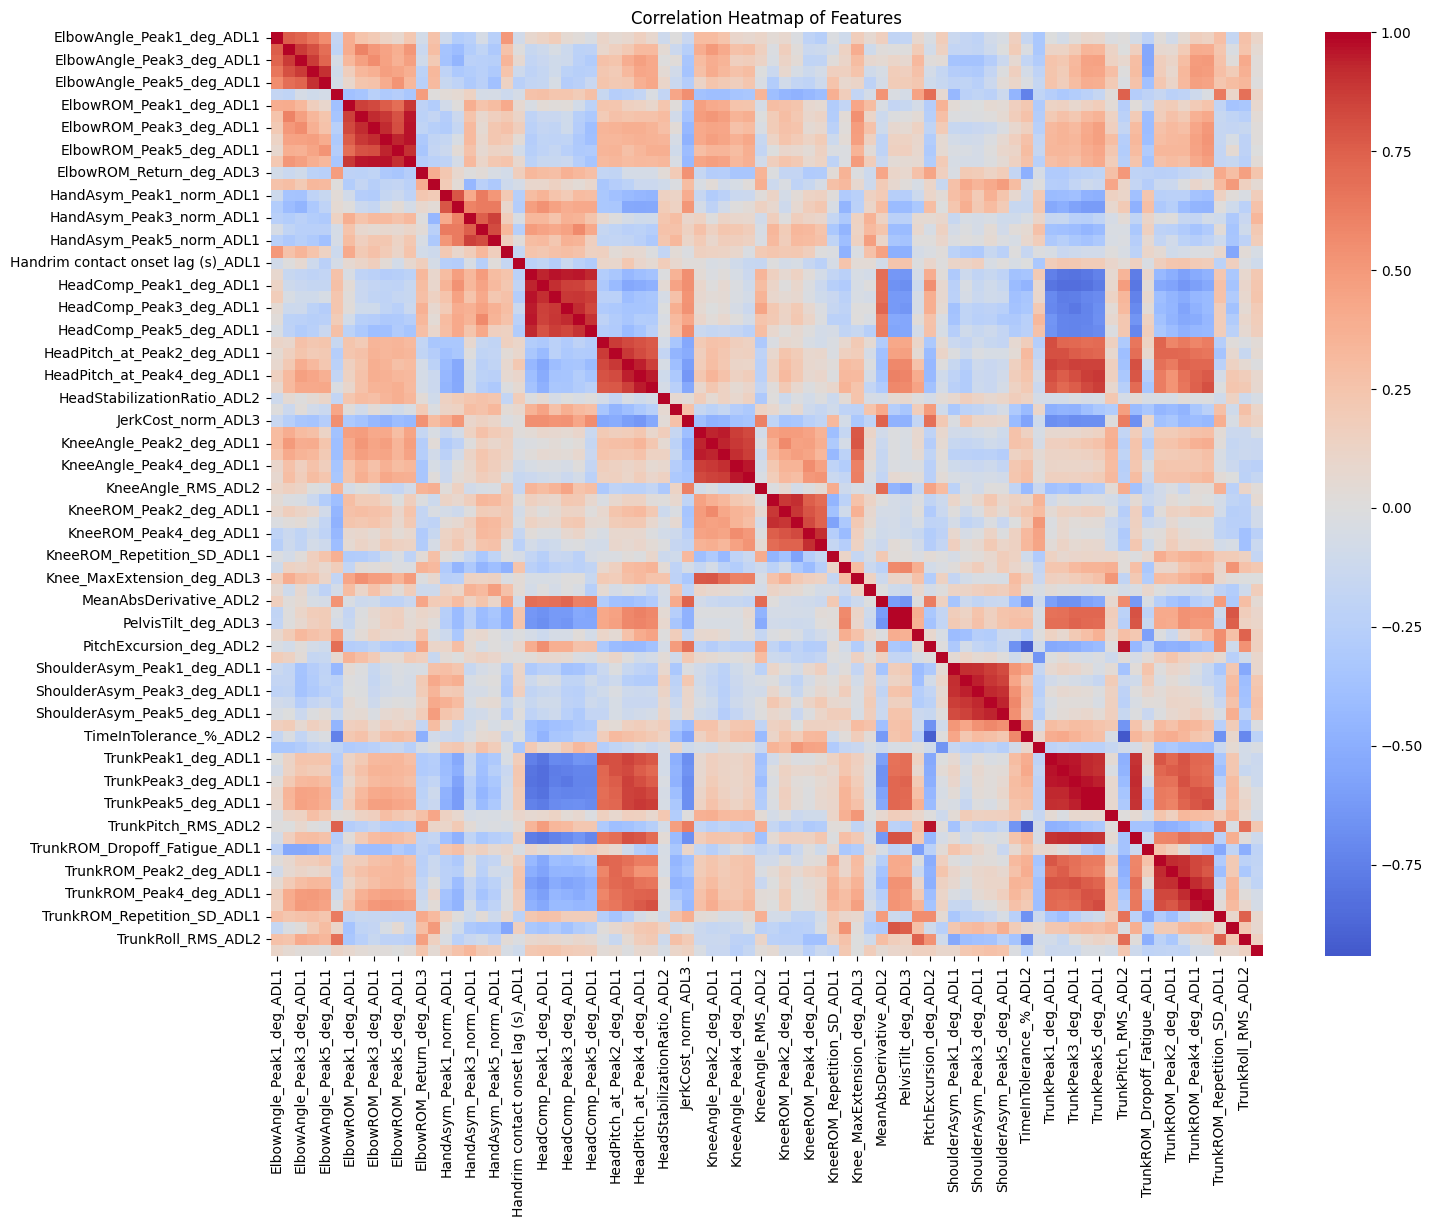

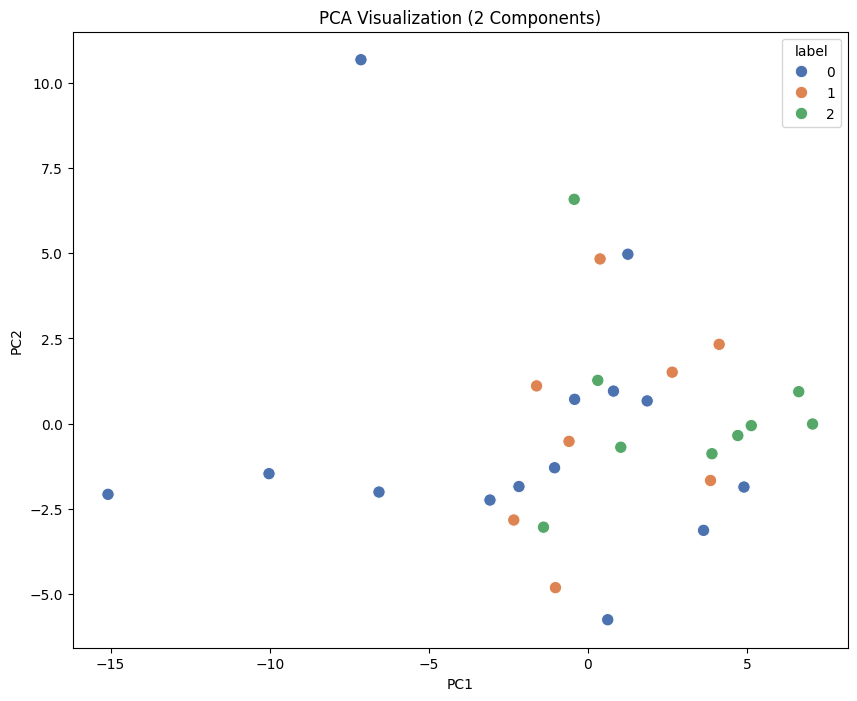


Explained variance: [0.27143256 0.12999101]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------
df = pd.read_csv("/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Combined_Features.csv")

# keep numeric features only
X = df.drop(columns=['label', 'dataset', 'patient'])
y = df['label']

# -------------------------------------------------------------
# 2. FEATURE SCORES (F-score + Mutual Information)
# -------------------------------------------------------------
f_scores, pvals = f_classif(X, y)
mi = mutual_info_classif(X, y, discrete_features=False)

feat_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': f_scores,
    'p_value': pvals,
    'mutual_info': mi
})

# sort by discriminative ability
feat_scores_sorted = feat_scores.sort_values("f_score", ascending=False)

print("\n===== TOP 20 FEATURES =====")
print(feat_scores_sorted.head(20))

print("\n===== WORST 20 FEATURES (Noise) =====")
print(feat_scores_sorted.tail(20))

# -------------------------------------------------------------
# 3. SAVE RESULTS
# -------------------------------------------------------------
feat_scores_sorted.to_csv("feature_selection_results.csv", index=False)

# -------------------------------------------------------------
# 4. CORRELATION HEATMAP
# -------------------------------------------------------------
plt.figure(figsize=(16, 12))
sns.heatmap(X.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Features")
plt.show()

# -------------------------------------------------------------
# 5. PCA VISUALIZATION OF SEPARABILITY
# -------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=y, palette="deep", s=80)
plt.title("PCA Visualization (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("\nExplained variance:", pca.explained_variance_ratio_)


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Combined_Features.csv")

# ------------------------------------------------------------
# 1. FAMILIES DEFINITELY REMOVED
# ------------------------------------------------------------
remove_families = [
    "HandAsym",
    "ShoulderAsym",
    "KneeROM",
    "TrunkRoll"
]

# ------------------------------------------------------------
# 2. OPTIONAL FAMILIES (DISABLED unless you enable them)
# ------------------------------------------------------------
optional_families = [
    "HeadPitch_at_Peak",       # weak but optional
    "TrunkROM_Repetition"      # weak but optional
]

USE_OPTIONAL = False  # change to True to remove optional families

families_to_remove = remove_families.copy()
if USE_OPTIONAL:
    families_to_remove += optional_families

# ------------------------------------------------------------
# 3. FIND & DROP FAMILY FEATURES
# ------------------------------------------------------------
cols_to_drop = [
    c for c in df.columns
    if any(c.startswith(prefix) for prefix in families_to_remove)
]

df_clean = df.drop(columns=cols_to_drop)

print("\nRemoved families:")
for f in families_to_remove:
    print(" -", f)

print("\nColumns removed from families:")
for c in cols_to_drop:
    print("   ", c)

# ------------------------------------------------------------
# 4. REMOVE THE 2 WORST INDIVIDUAL FEATURES
# ------------------------------------------------------------
remove_individual = [
    "TrunkPelvisCorr_ADL3",
    "TrunkROM_deg_ADL3"
]

df_clean = df_clean.drop(columns=[c for c in remove_individual if c in df_clean.columns])

print("\nRemoved individual noisy features:")
for c in remove_individual:
    if c in df.columns:
        print(" -", c)

# ------------------------------------------------------------
# 5. SAVE CLEANED DATASET
# ------------------------------------------------------------
print("\nFinal shape after all cleaning:", df_clean.shape)

df_clean.to_csv("Combined_Features_CLEANED.csv", index=False)
print("\nSaved cleaned dataset to Combined_Features_CLEANED.csv")



Removed families:
 - HandAsym
 - ShoulderAsym
 - KneeROM
 - TrunkRoll

Columns removed from families:
    HandAsym_Peak1_norm_ADL1
    HandAsym_Peak2_norm_ADL1
    HandAsym_Peak3_norm_ADL1
    HandAsym_Peak4_norm_ADL1
    HandAsym_Peak5_norm_ADL1
    HandAsym_norm_ADL3
    KneeROM_Peak1_deg_ADL1
    KneeROM_Peak2_deg_ADL1
    KneeROM_Peak3_deg_ADL1
    KneeROM_Peak4_deg_ADL1
    KneeROM_Peak5_deg_ADL1
    KneeROM_Repetition_SD_ADL1
    ShoulderAsym_Peak1_deg_ADL1
    ShoulderAsym_Peak2_deg_ADL1
    ShoulderAsym_Peak3_deg_ADL1
    ShoulderAsym_Peak4_deg_ADL1
    ShoulderAsym_Peak5_deg_ADL1
    ShoulderAsym_deg_ADL3
    TrunkRoll_RMS_ADL2
    TrunkRoll_RMS_ADL3

Removed individual noisy features:
 - TrunkPelvisCorr_ADL3
 - TrunkROM_deg_ADL3

Final shape after all cleaning: (31, 63)

Saved cleaned dataset to Combined_Features_CLEANED.csv


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("Combined_Features_CLEANED.csv")

# Identify features per ADL level
adl1 = [c for c in df.columns if "ADL1" in c]
adl2 = [c for c in df.columns if "ADL2" in c]
adl3 = [c for c in df.columns if "ADL3" in c]

# Print counts
print("ADL1 count:", len(adl1))
print("ADL2 count:", len(adl2))
print("ADL3 count:", len(adl3))

# Make a small summary table
adl_counts = pd.DataFrame({
    "ADL Level": ["ADL1", "ADL2", "ADL3"],
    "Count": [len(adl1), len(adl2), len(adl3)]
})

print("\nSummary:\n")
print(adl_counts)


ADL1 count: 41
ADL2 count: 9
ADL3 count: 10

Summary:

  ADL Level  Count
0      ADL1     41
1      ADL2      9
2      ADL3     10


🔍 Number of features: 82
📁 Saved ranking to Feature_Ranking.csv


/tmp/ipython-input-3745467931.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ANOVA_F', y='feature', data=anova_rank, palette='viridis')


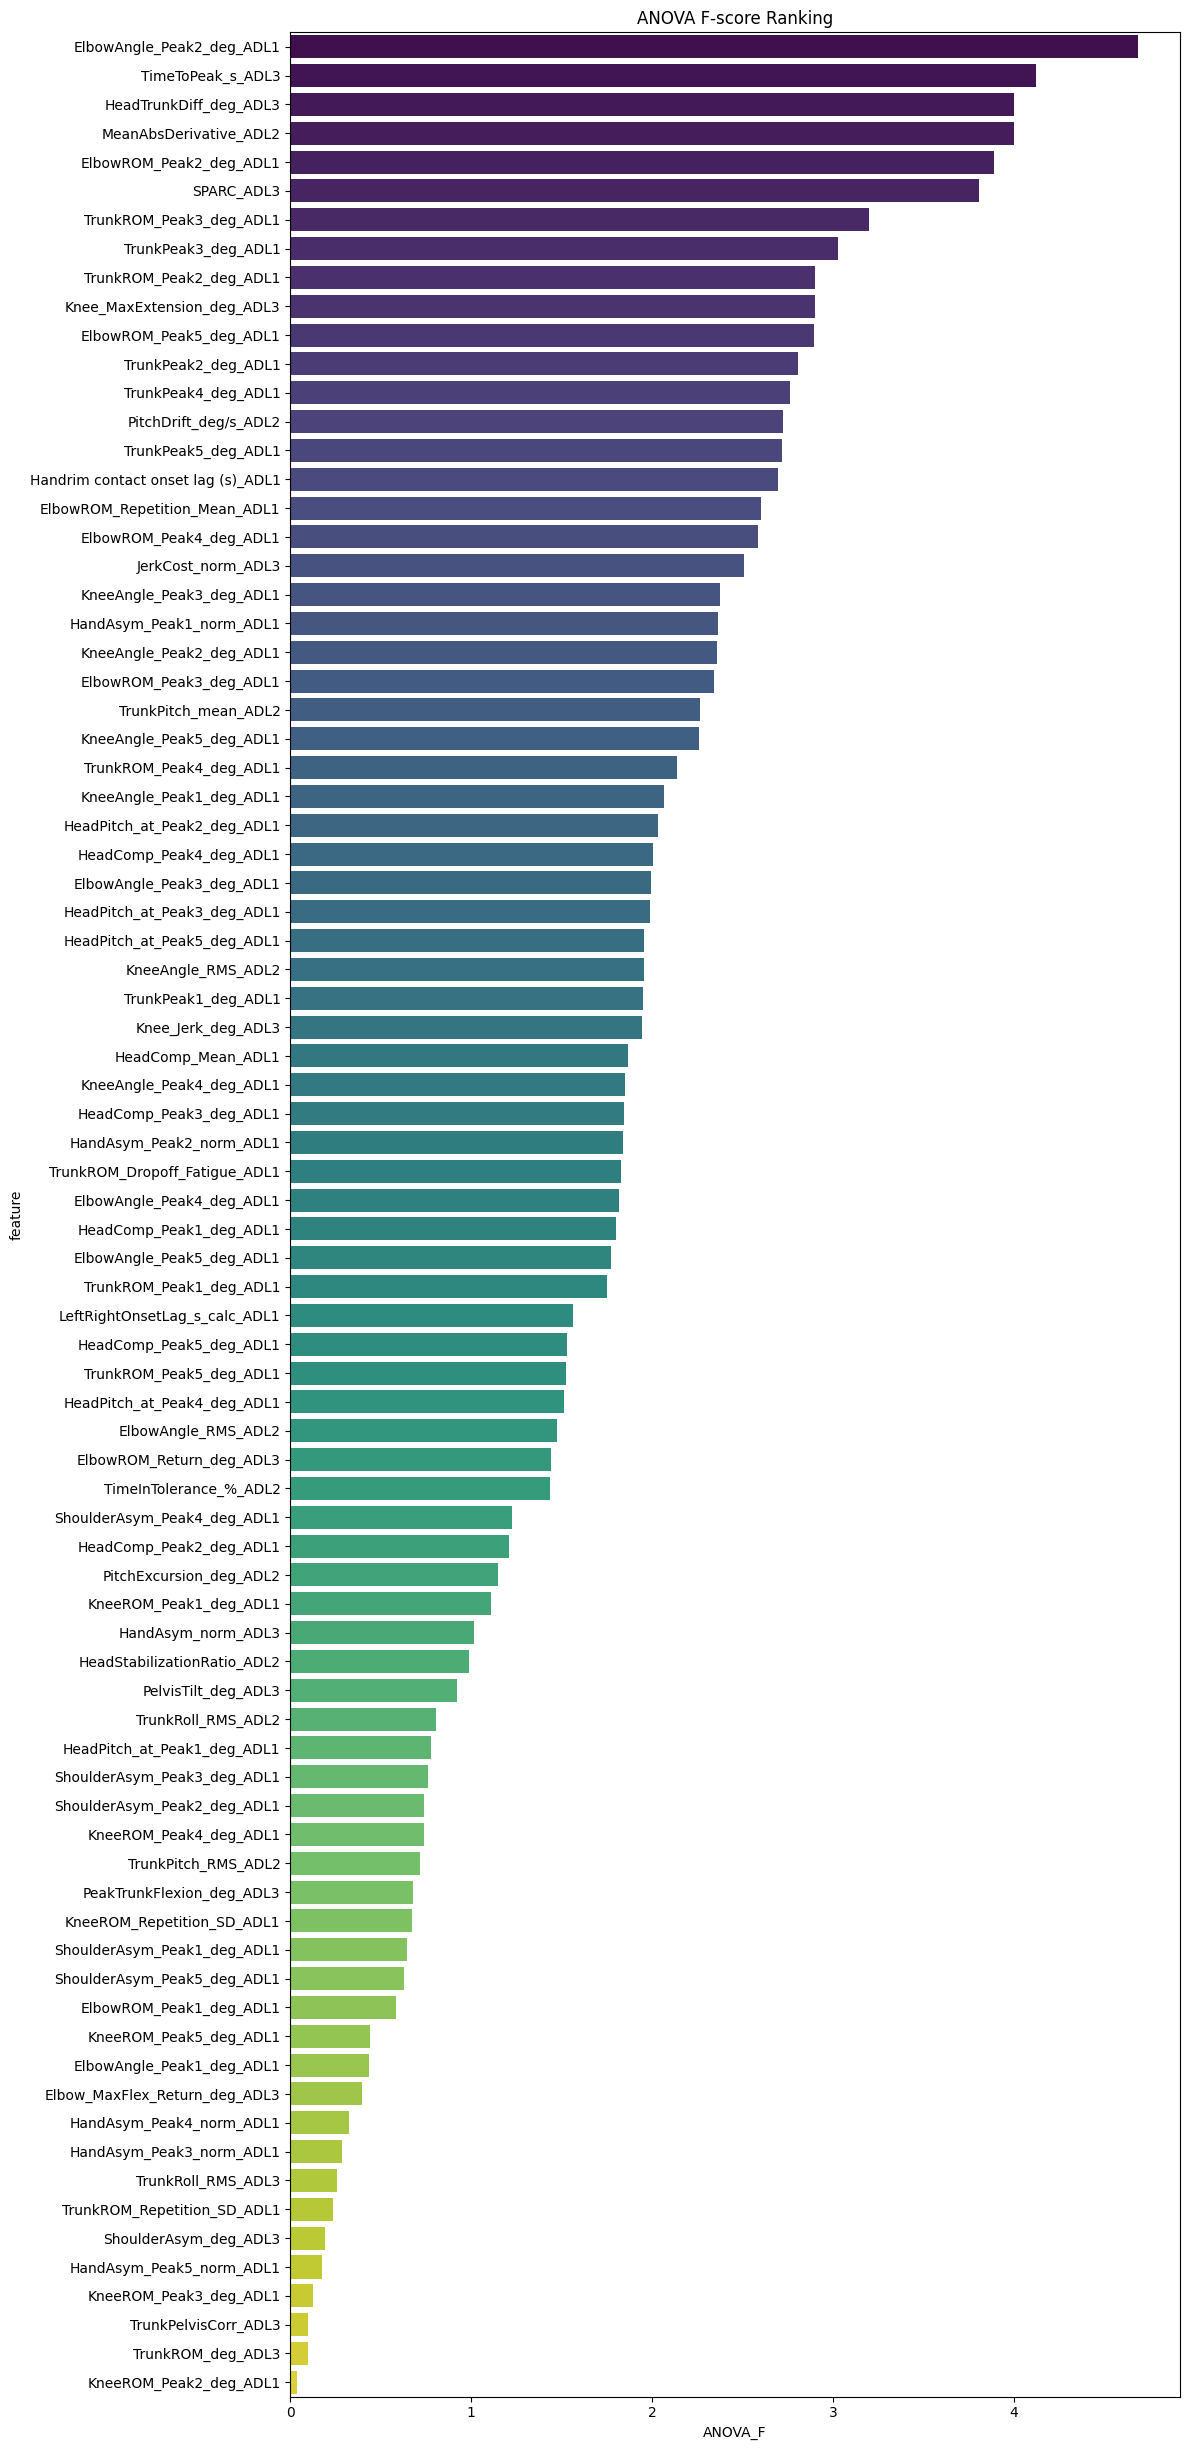

/tmp/ipython-input-3745467931.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI', y='feature', data=mi_rank, palette='rocket')


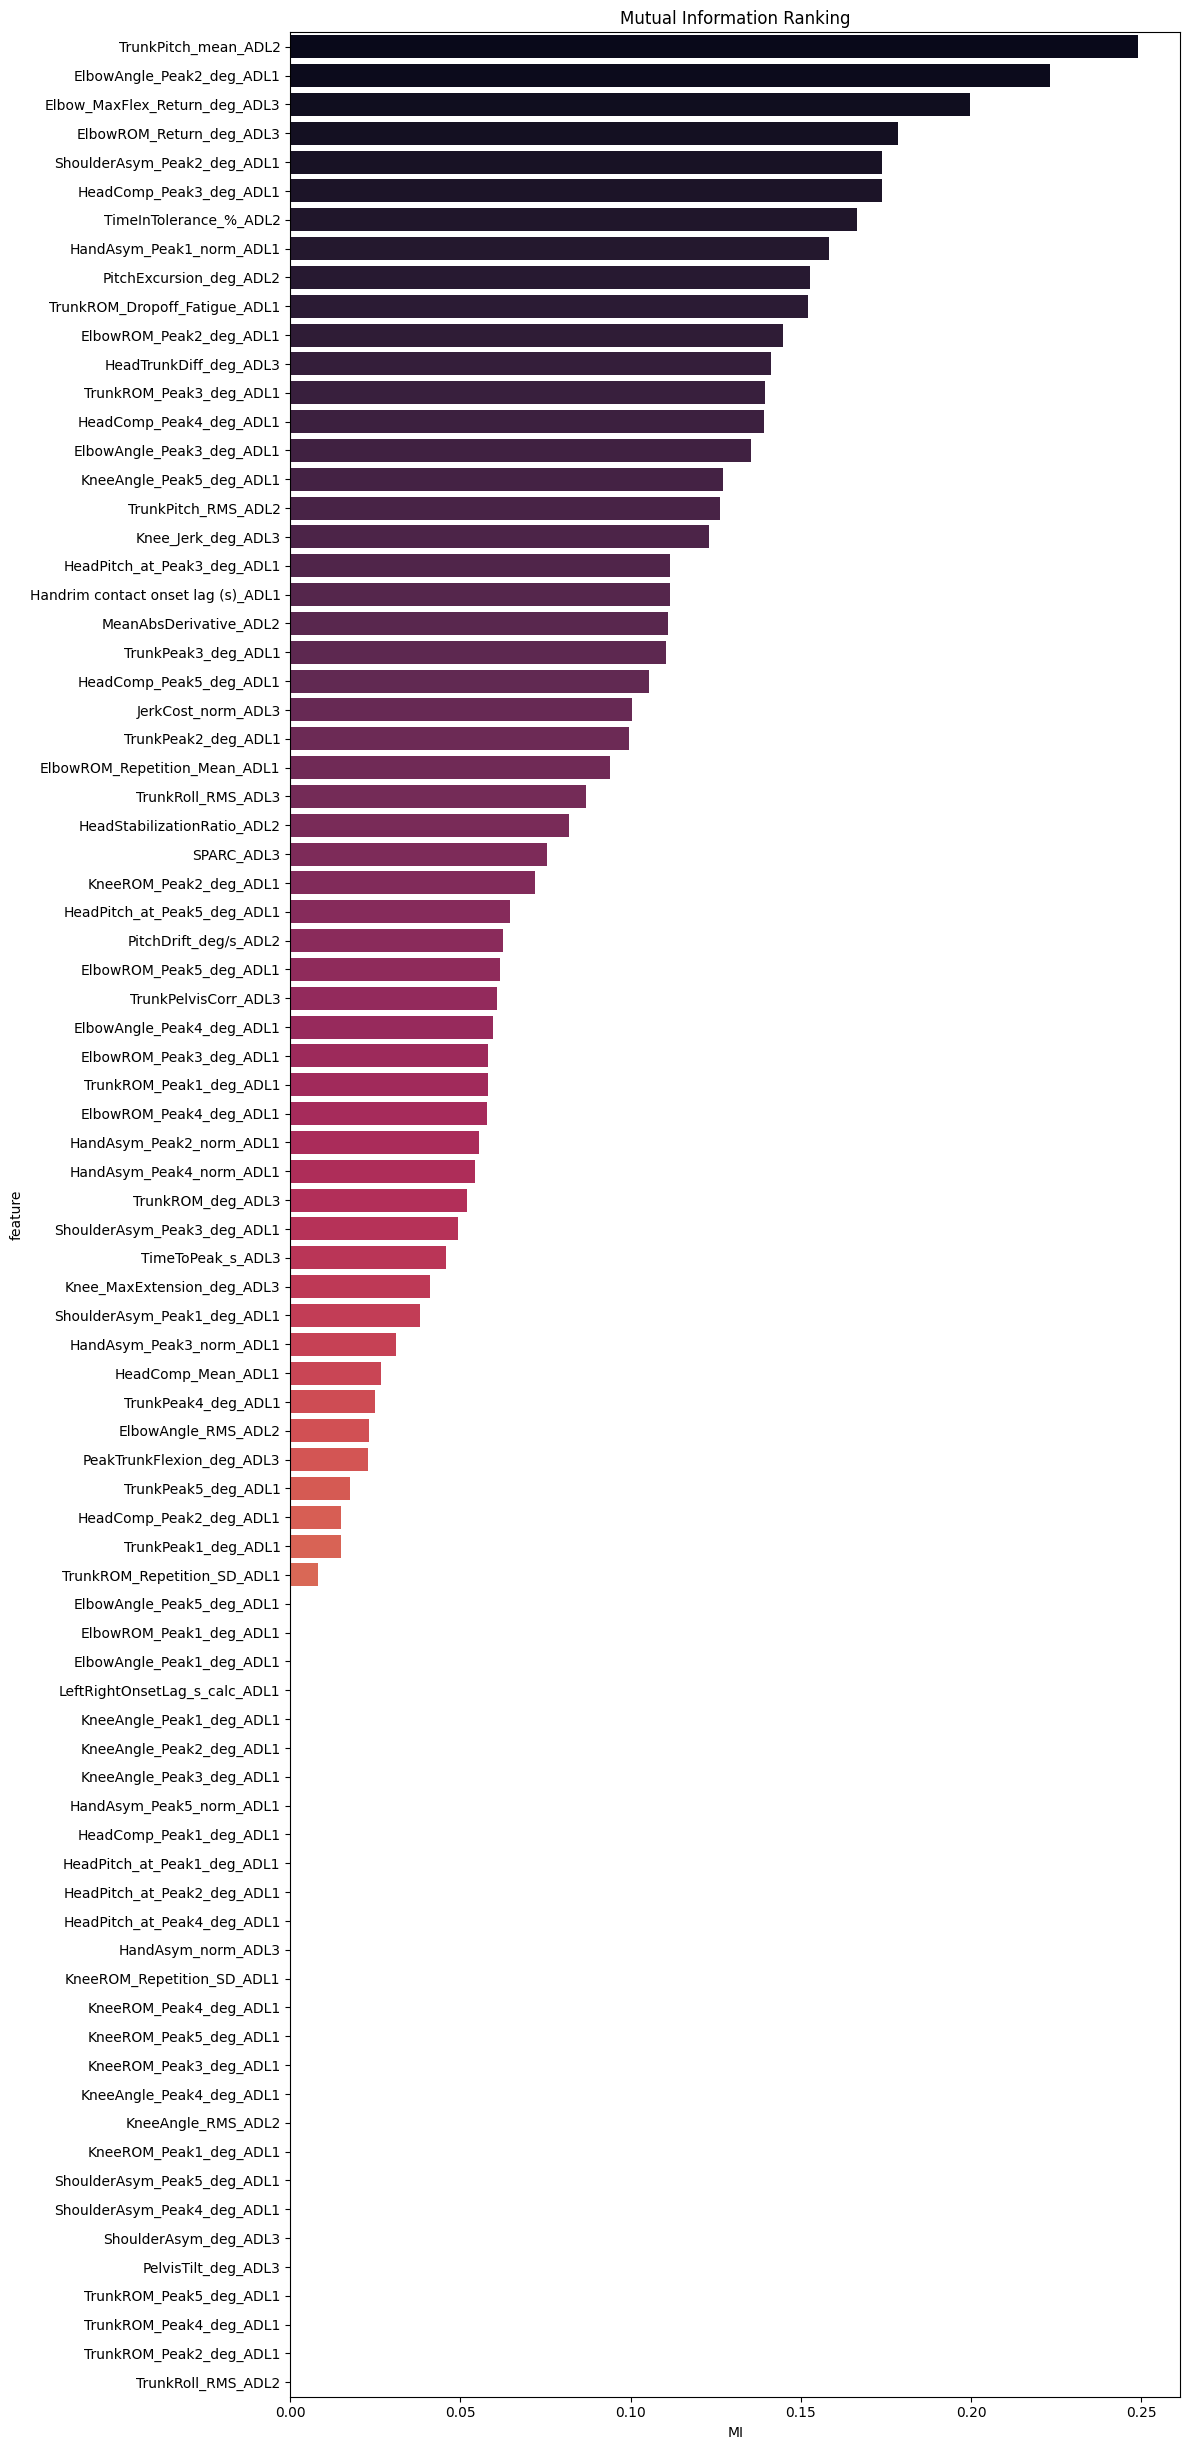

/tmp/ipython-input-3745467931.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RF_importance', y='feature', data=rf_rank, palette='mako')


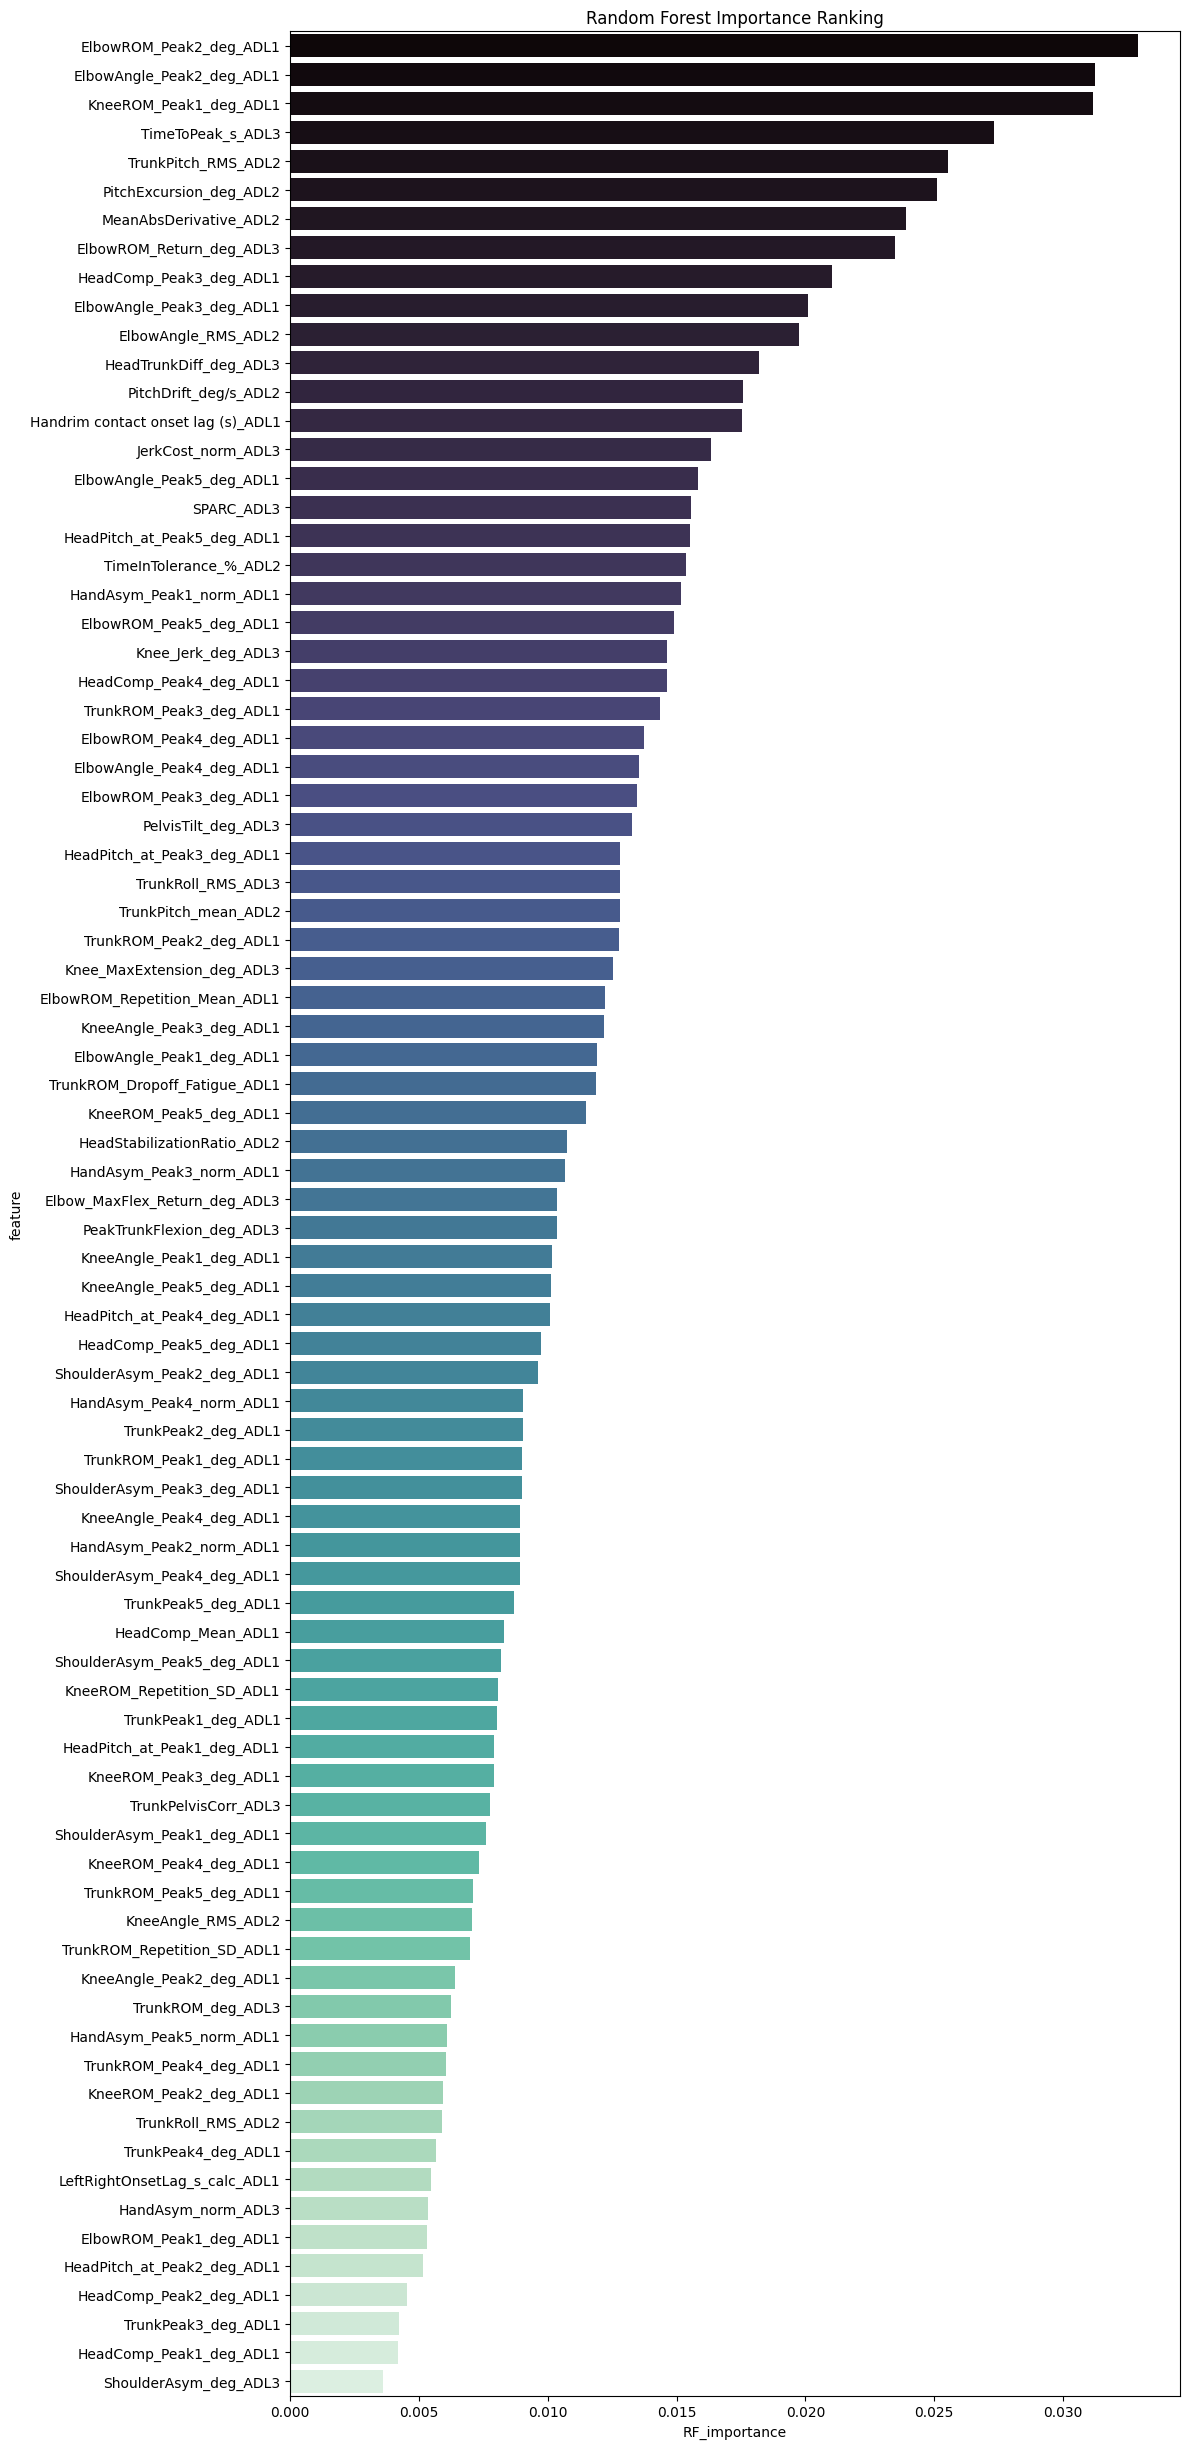

/tmp/ipython-input-3745467931.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CombinedScore', y='feature', data=combined_sorted, palette='coolwarm')


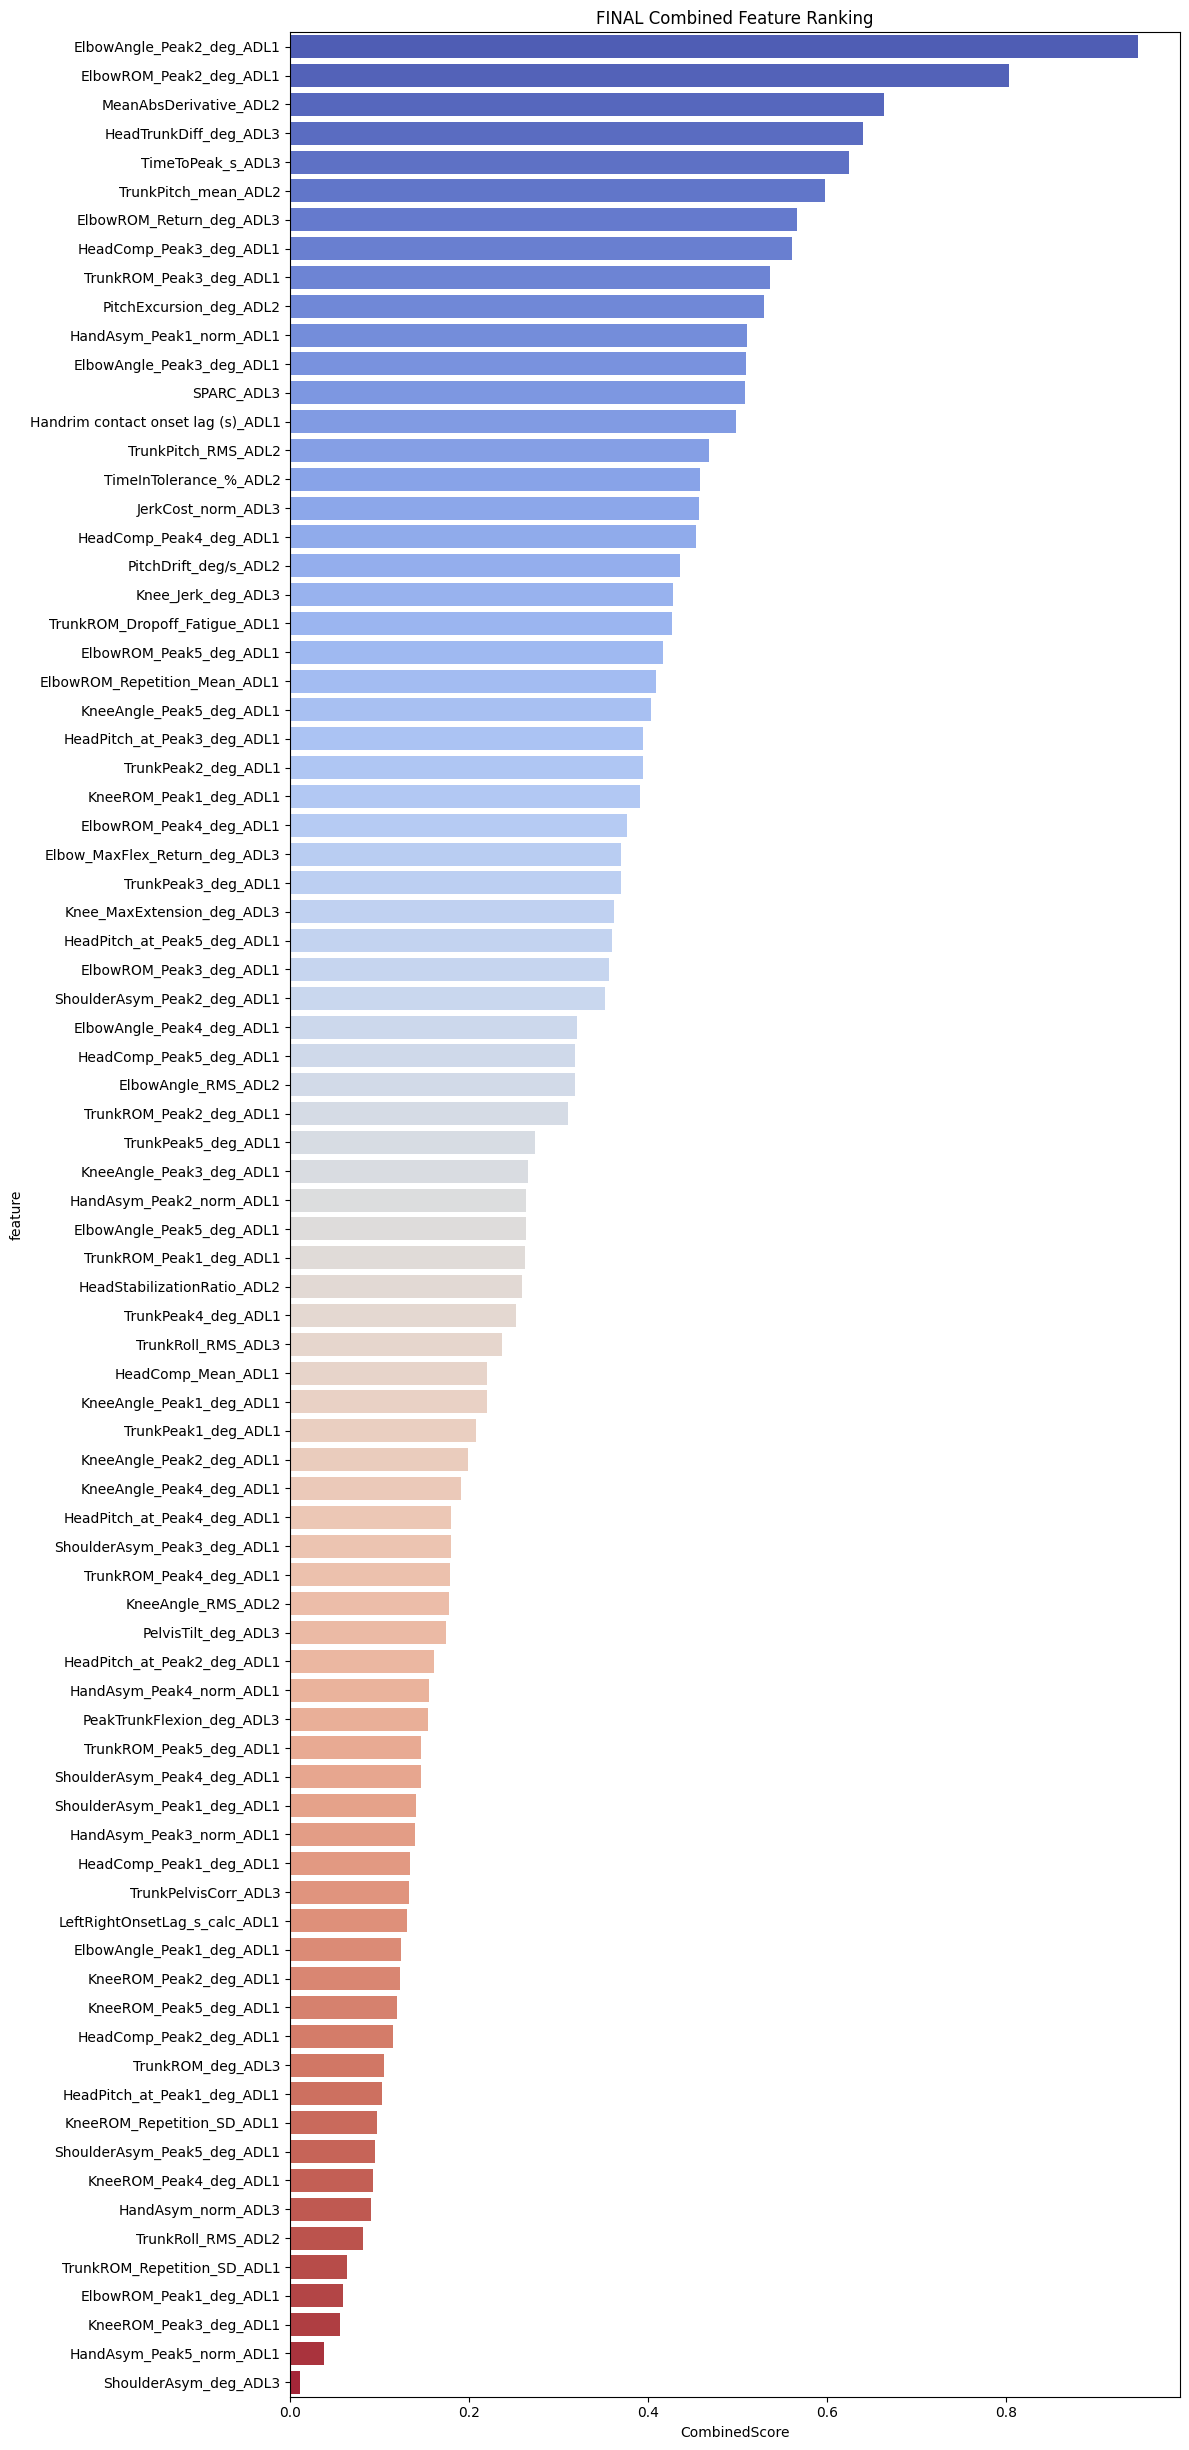

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# ===============================================================
# 1. Select numeric feature columns
# ===============================================================
df = df_all.copy()

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['label']]  # remove label

X = df[numeric_cols]
y = df['label']

print("🔍 Number of features:", len(numeric_cols))

# ===============================================================
# 2. ANOVA F-score ranking
# ===============================================================
F_values, p_values = f_classif(X, y)

anova_rank = pd.DataFrame({
    'feature': numeric_cols,
    'ANOVA_F': F_values,
    'ANOVA_p': p_values
}).sort_values(by='ANOVA_F', ascending=False)

# ===============================================================
# 3. Mutual Information ranking
# ===============================================================
MI_values = mutual_info_classif(X, y, random_state=42)

mi_rank = pd.DataFrame({
    'feature': numeric_cols,
    'MI': MI_values
}).sort_values(by='MI', ascending=False)

# ===============================================================
# 4. Random Forest importance ranking
# ===============================================================
rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X, y)

rf_rank = pd.DataFrame({
    'feature': numeric_cols,
    'RF_importance': rf.feature_importances_
}).sort_values(by='RF_importance', ascending=False)

# ===============================================================
# 5. COMBINE ALL RANKINGS
# ===============================================================
combined = pd.DataFrame({'feature': numeric_cols})
combined = combined.merge(anova_rank[['feature', 'ANOVA_F']], on='feature')
combined = combined.merge(mi_rank[['feature', 'MI']], on='feature')
combined = combined.merge(rf_rank[['feature', 'RF_importance']], on='feature')

# Normalize each metric for combined ranking
for col in ['ANOVA_F', 'MI', 'RF_importance']:
    combined[col + '_norm'] = (combined[col] - combined[col].min()) / (combined[col].max() - combined[col].min())

# Final combined score
combined['CombinedScore'] = combined[['ANOVA_F_norm', 'MI_norm', 'RF_importance_norm']].mean(axis=1)

combined_sorted = combined.sort_values(by='CombinedScore', ascending=False)

# ===============================================================
# 6. SAVE CSV WITH ALL RESULTS
# ===============================================================
combined_sorted.to_csv('/content/drive/MyDrive/Wheelchair_Project/PPBFeatures/Combined/Feature_Ranking.csv',
                       index=False)

print("📁 Saved ranking to Feature_Ranking.csv")

# ===============================================================
# 7. PLOTS
# ===============================================================
plt.figure(figsize=(12, len(combined_sorted) * 0.30))
sns.barplot(x='ANOVA_F', y='feature', data=anova_rank, palette='viridis')
plt.title("ANOVA F-score Ranking")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, len(combined_sorted) * 0.30))
sns.barplot(x='MI', y='feature', data=mi_rank, palette='rocket')
plt.title("Mutual Information Ranking")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, len(combined_sorted) * 0.30))
sns.barplot(x='RF_importance', y='feature', data=rf_rank, palette='mako')
plt.title("Random Forest Importance Ranking")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, len(combined_sorted) * 0.30))
sns.barplot(x='CombinedScore', y='feature', data=combined_sorted, palette='coolwarm')
plt.title("FINAL Combined Feature Ranking")
plt.tight_layout()
plt.show()
